In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

#%load_ext line_profiler
#%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#import yep

In [3]:
nst = 256
nsm = 1024
nips = 4;
nrps = 4;
nb = 32
measperiod =2;
nt = 128
nh = 1
ncores = 4
nmaxiter = 1
L = 8
J1 = 1
J2 = 0.1
h = 0

stroutput = "PSIJ1J2__J1={0}_J2={2}_L={1}_nrps={3}_Both".format(J1,L,J2,nrps)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = 0.0,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--measupdatev', type = int, default = 0,
                       help = '''select the version of measupdate''')
    parser.add_argument('--measupdatesave', default = False, action = 'store_true',
                       help = '''activate to cancel measurement update before continuing''')
    parser.add_argument('--p', type = float, default = 0, 
                       help = '''version 0: prob of the measuring tip flipping the spin (number between 0 and 1)
                       \n version 1: htip/J (try 0, 2, 4)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = False, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.0005,60],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--frustratedT', default = True, action = 'store_true',
                        help = 'activate if you want to save the frustrated triangles')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--both', default = True, action = 'store_true',
                        help = '''activate if you want to save both types of correlations''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    parser.add_argument('--sref0', nargs = '+', type = int, default = [L-2, L-1, 0], help = 'ref spin 0')
    parser.add_argument('--sref1', nargs = '+', type = int, default = [L-2, L-1, 1], help = 'ref spin 1')
    parser.add_argument('--sref2', nargs = '+', type = int, default = [L-2, L-1, 2], help = 'ref spin 2')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = False, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args



In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
#%lprun -f dw.mcs_swaps 
[meanstat, swapst, swapsh, failedupdatesth, failedupdates, failedssfupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./PSIJ1J2__J1=1_J2=0.1_L=8_nrps=4_Both_folder/backup.hkl
Lattice side size:  8
J1  1
J2  0.1
J3  0.0
J3st  0.0
Couplings extracted
Hamiltonian expression (without field) computed
Number of temperatures:  128
Temperatures: [5.00000000e-04 5.48230960e-04 6.01114371e-04 6.59099017e-04
 7.22676973e-04 7.92387781e-04 8.68823028e-04 9.52631365e-04
 1.04452401e-03 1.14528081e-03 1.25575679e-03 1.37688950e-03
 1.50970691e-03 1.65533613e-03 1.81501303e-03 1.99009267e-03
 2.18206083e-03 2.39254661e-03 2.62333625e-03 2.87638830e-03
 3.15385024e-03 3.45807669e-03 3.79164940e-03 4.15739918e-03
 4.55842989e-03 4.99814478e-03 5.48027542e-03 6.00891331e-03
 6.58854462e-03 7.22408828e-03 7.92093771e-03 8.68500656e-03
 9.52277897e-03 1.04413645e-02 1.14485586e-02 1.25529085e-02
 1.37637862e-02 1.50914674e-02 1.65472193e-02 1.81433958e-02
 1.98935426e-02 2.18125119e-02 2.39165887e-02 2.62236288e-02
 2.87532104e-02 3.15268002e-02 3.45679359e-02 3.79024

In [7]:
54/(nsm*measperiod*nips)

0.006591796875

In [8]:
failedupdates

array([[1567],
       [1577],
       [1569],
       [1557],
       [1599],
       [1544],
       [1533],
       [1561],
       [1558],
       [1597],
       [1519],
       [1543],
       [1578],
       [1567],
       [1561],
       [1538],
       [1589],
       [1527],
       [1590],
       [1502],
       [1587],
       [1545],
       [1544],
       [1533],
       [1525],
       [1548],
       [1557],
       [1562],
       [1550],
       [1590],
       [1562],
       [1557],
       [1537],
       [1552],
       [1552],
       [1526],
       [1594],
       [1587],
       [1529],
       [1550],
       [1532],
       [1587],
       [1556],
       [1555],
       [1501],
       [1548],
       [1562],
       [1567],
       [1579],
       [1586],
       [1620],
       [1616],
       [1668],
       [1712],
       [1764],
       [1782],
       [1821],
       [1852],
       [1876],
       [1892],
       [1923],
       [1904],
       [1944],
       [1927],
       [1928],
       [1908],
       [18

In [9]:
failedssfupdates

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [26]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jeanne/Documents/Codes/Codes_DipolarIsingModel/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [27]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [28]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref, idswalker] =\
af.LoadParameters(foldername, filenamelist)

In [29]:
s_ijl, ijl_s = kdraw.createspinsitetable(L[0])
print("nb ", nb, "num_in_bin ", num_in_bin)
swapst_th, swapsh_th, swapst, swapsh = af.LoadSwaps(foldername, filenamelist, nb, num_in_bin, nh, nt)

n = len(L)
failedth, failedssfth, failed, failedssf = \
af.LoadUpdates(foldername, filenamelist, nb, num_in_bin, [9*L[i]**2 for i in range(n)])


nb  [32] num_in_bin  [32]


In [30]:
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]

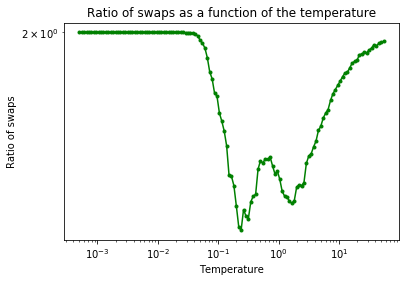

In [31]:
af.SwapsAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername, swapst, swapsh)

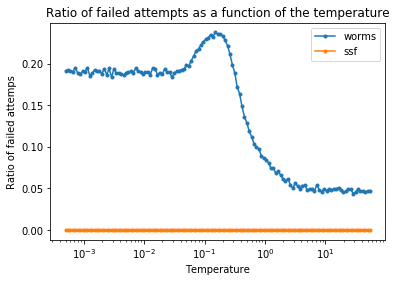

In [32]:
af.FailedAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername,failed, failedssf)

Binning...Energy
 bins list for binning:  [32, 16]
plotting!


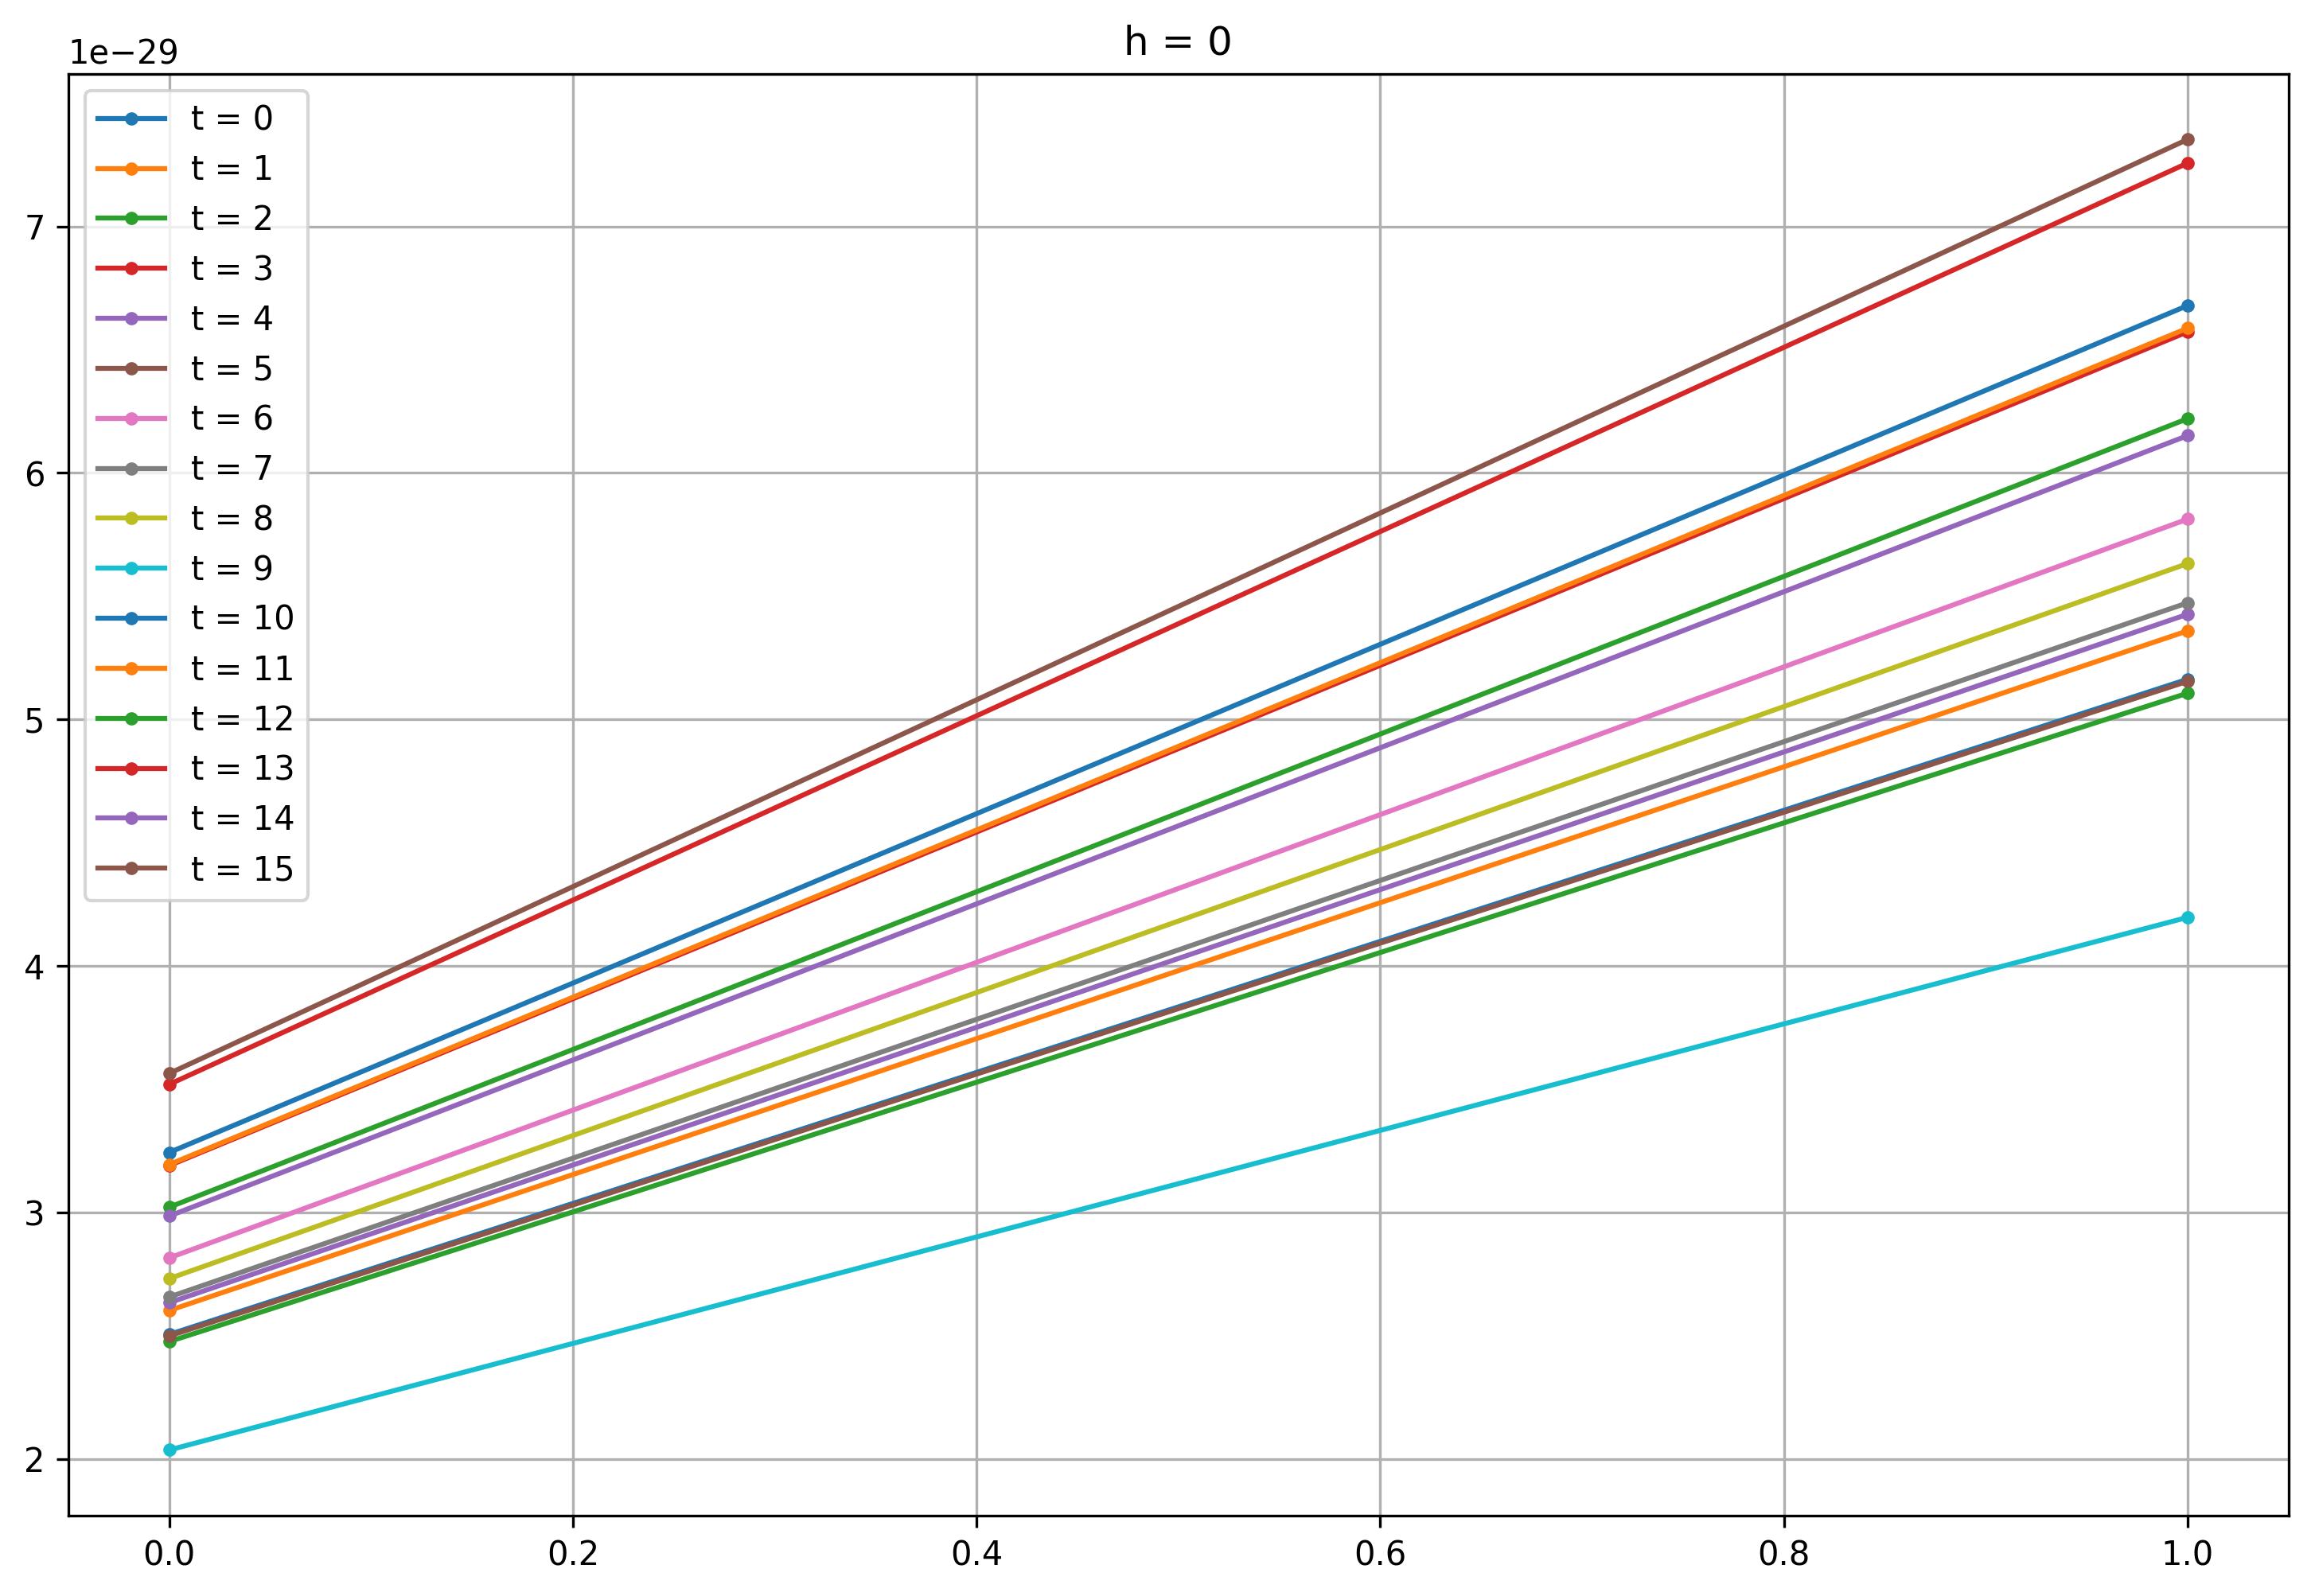

[-0.73333333]
Binning...Energy
 bins list for binning:  [32, 16]
plotting!


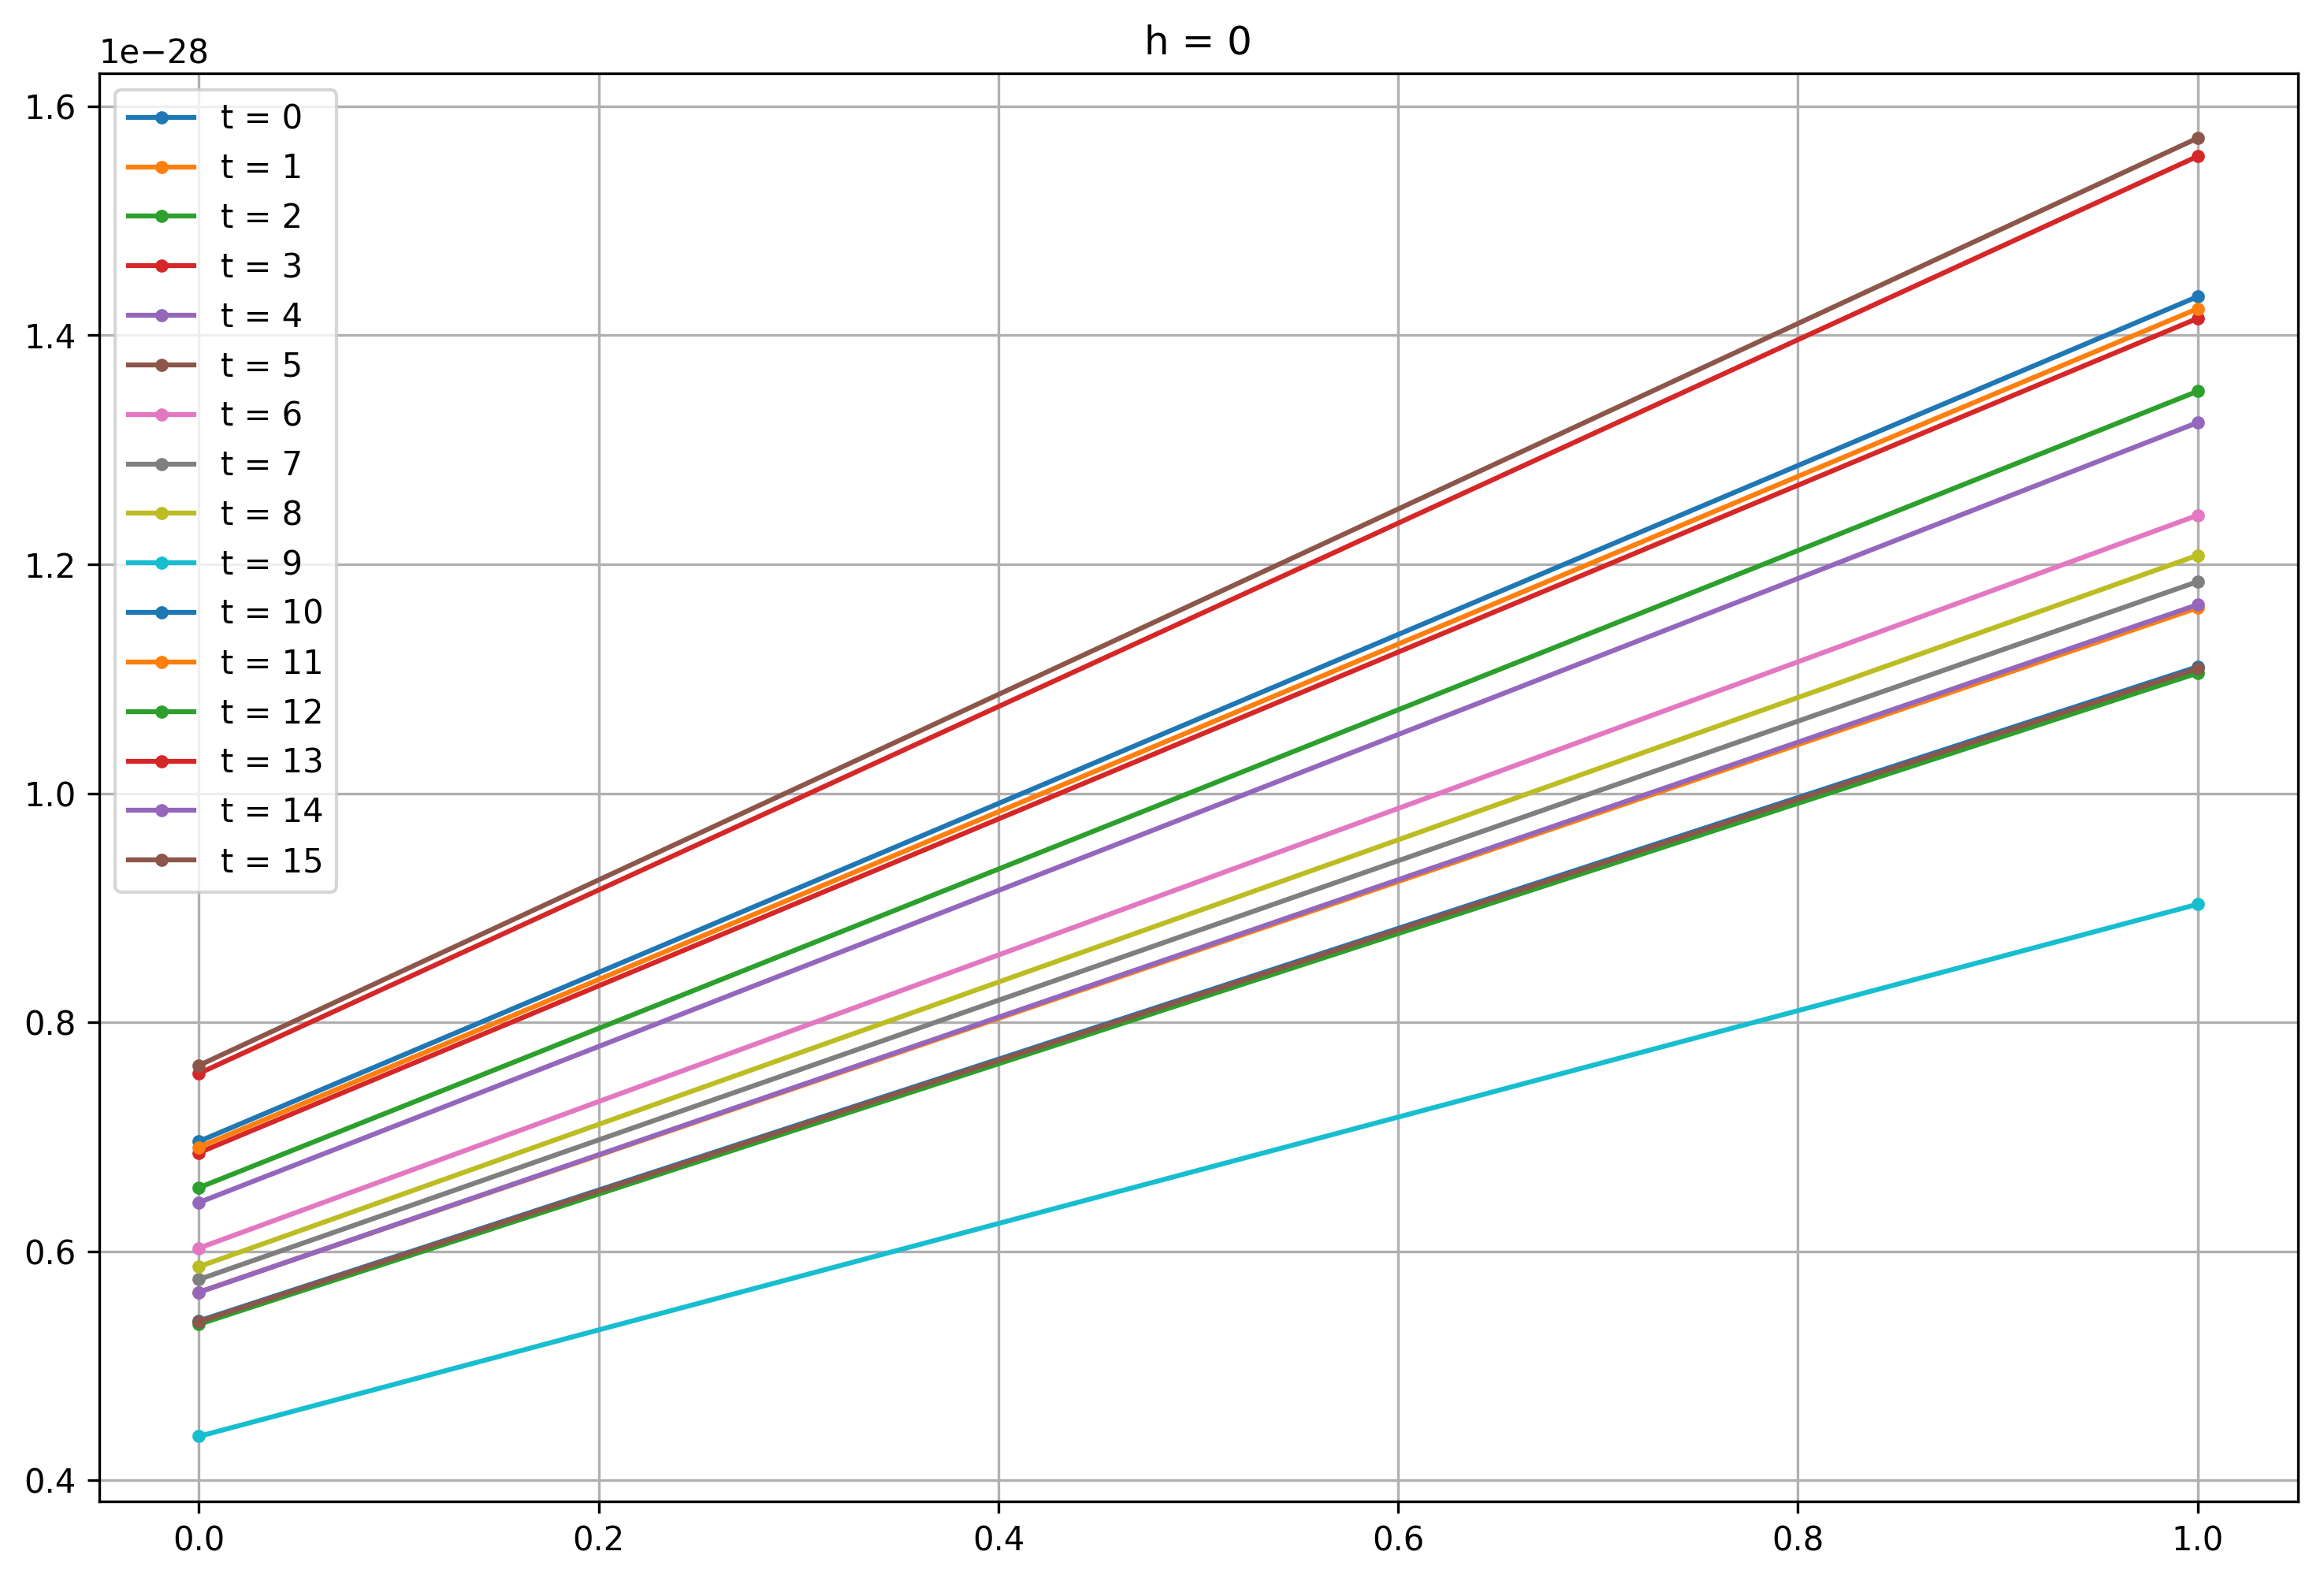

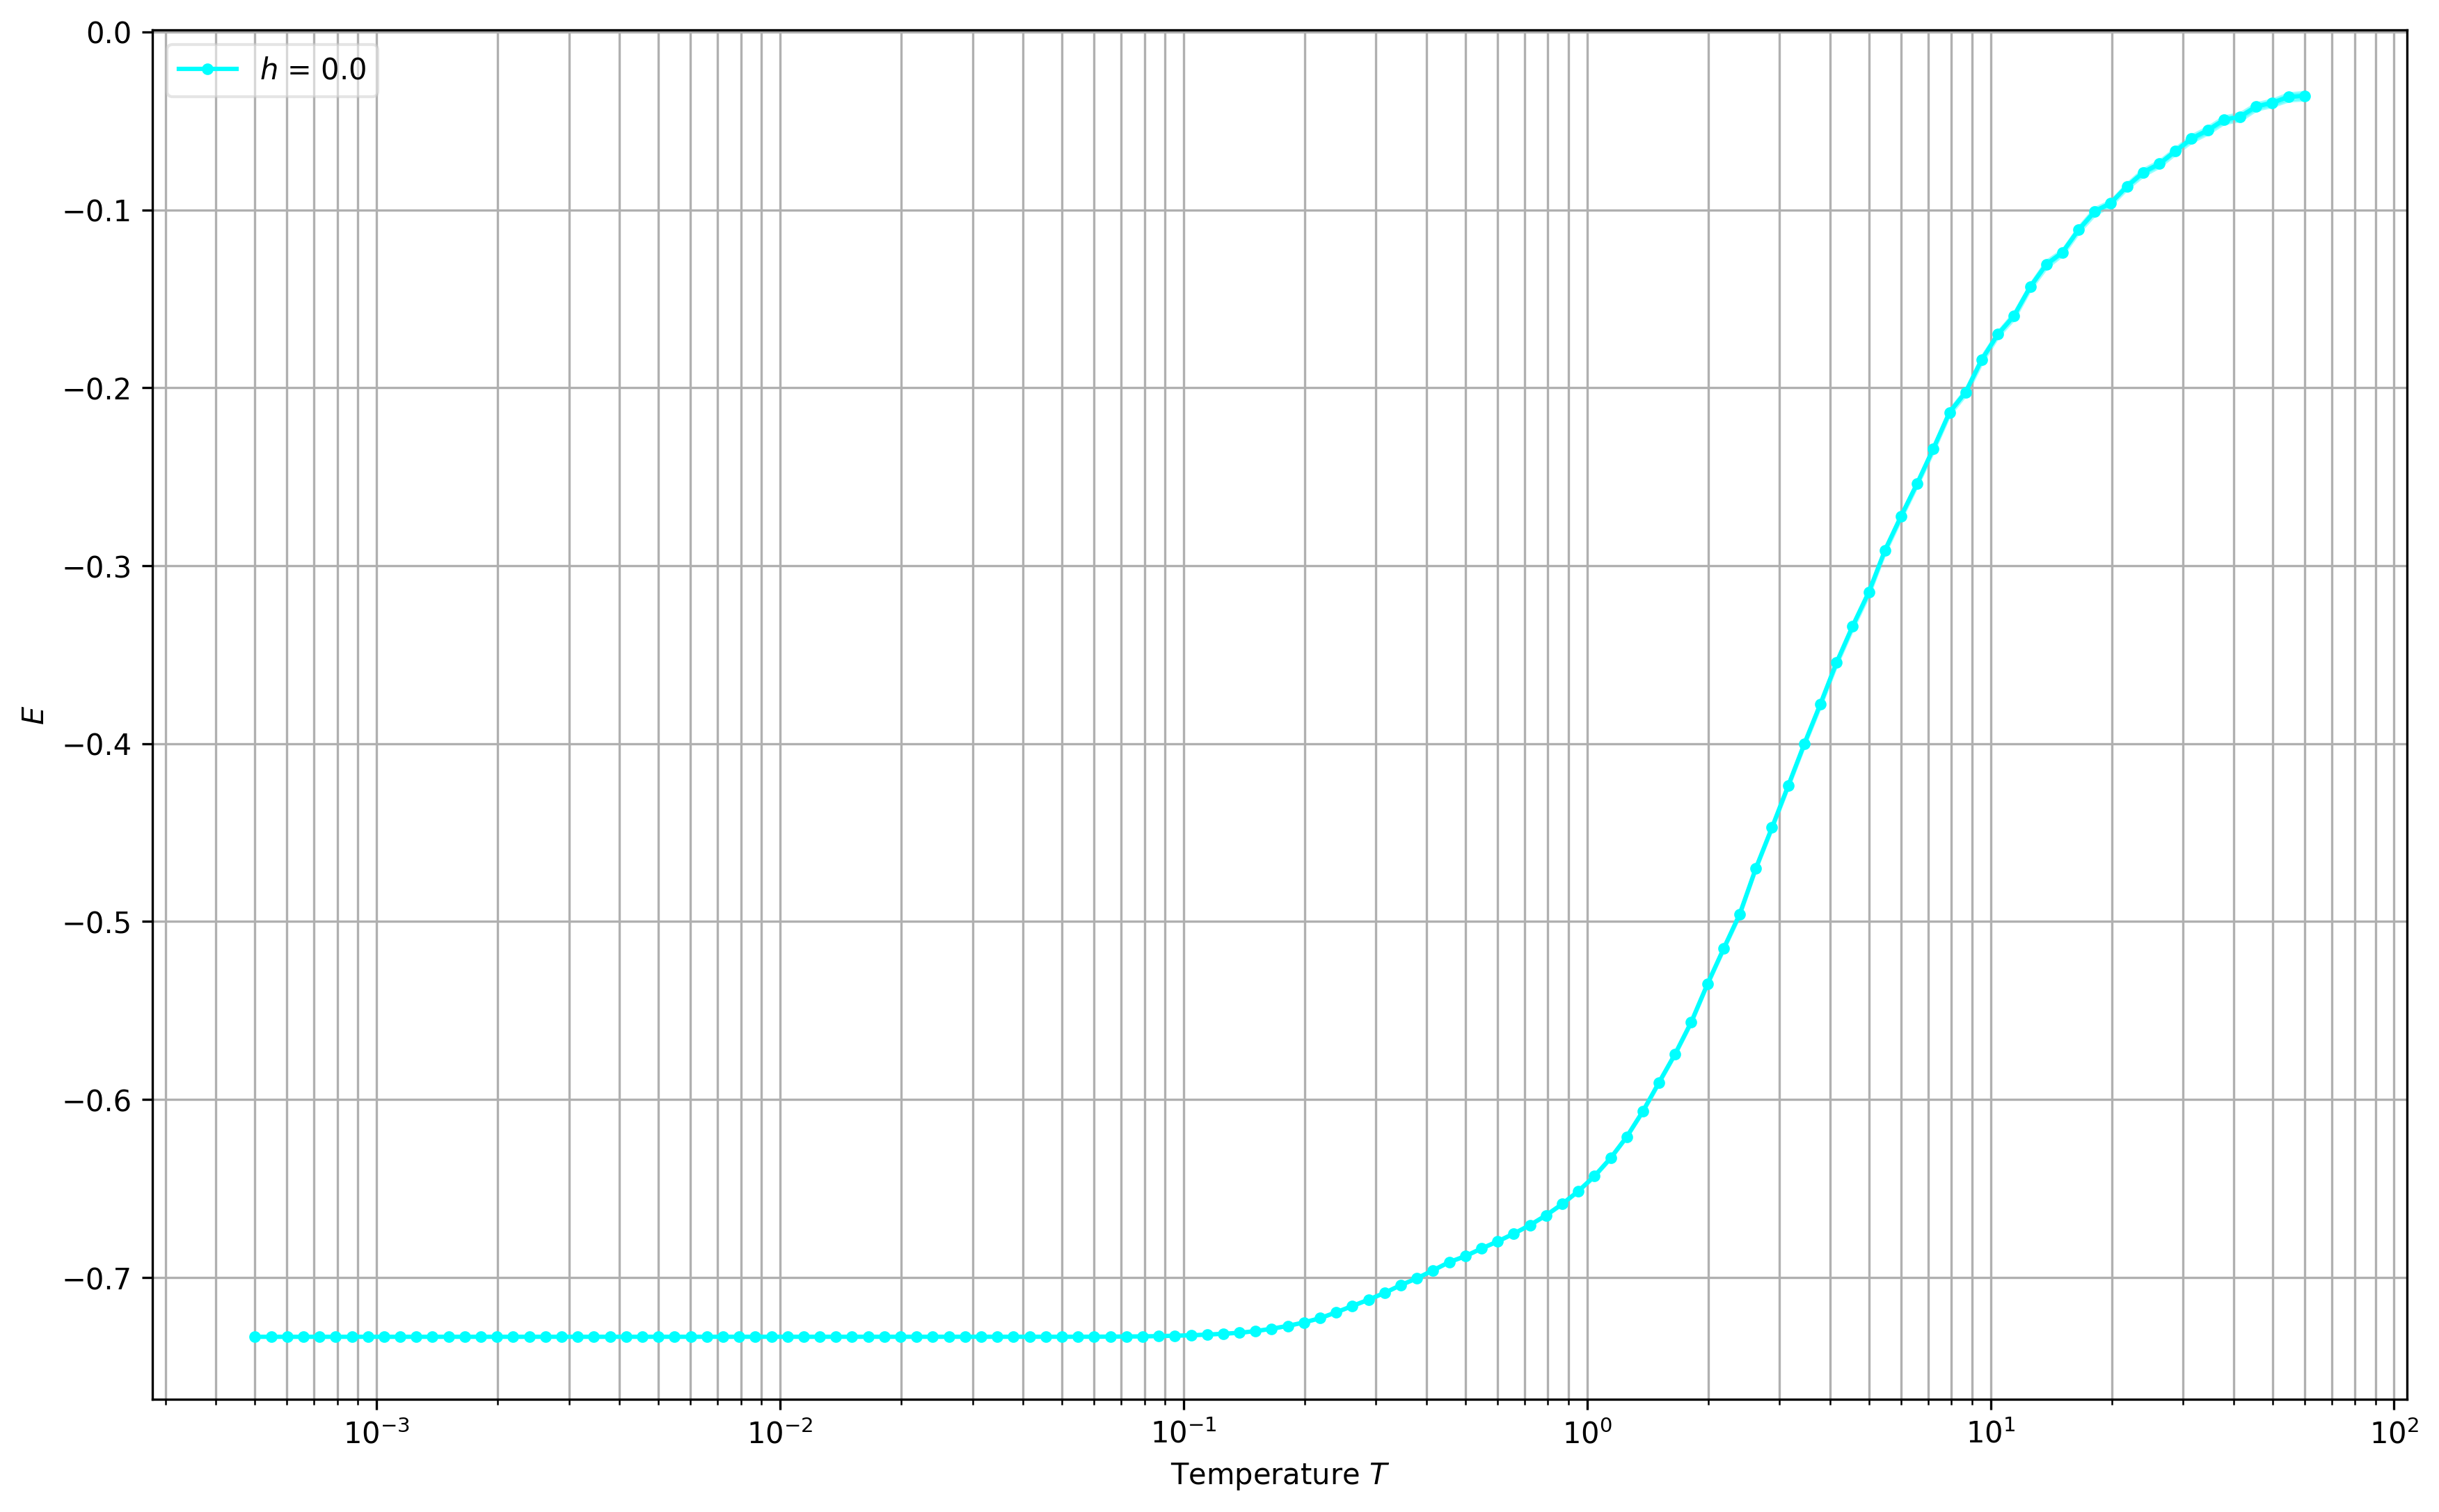

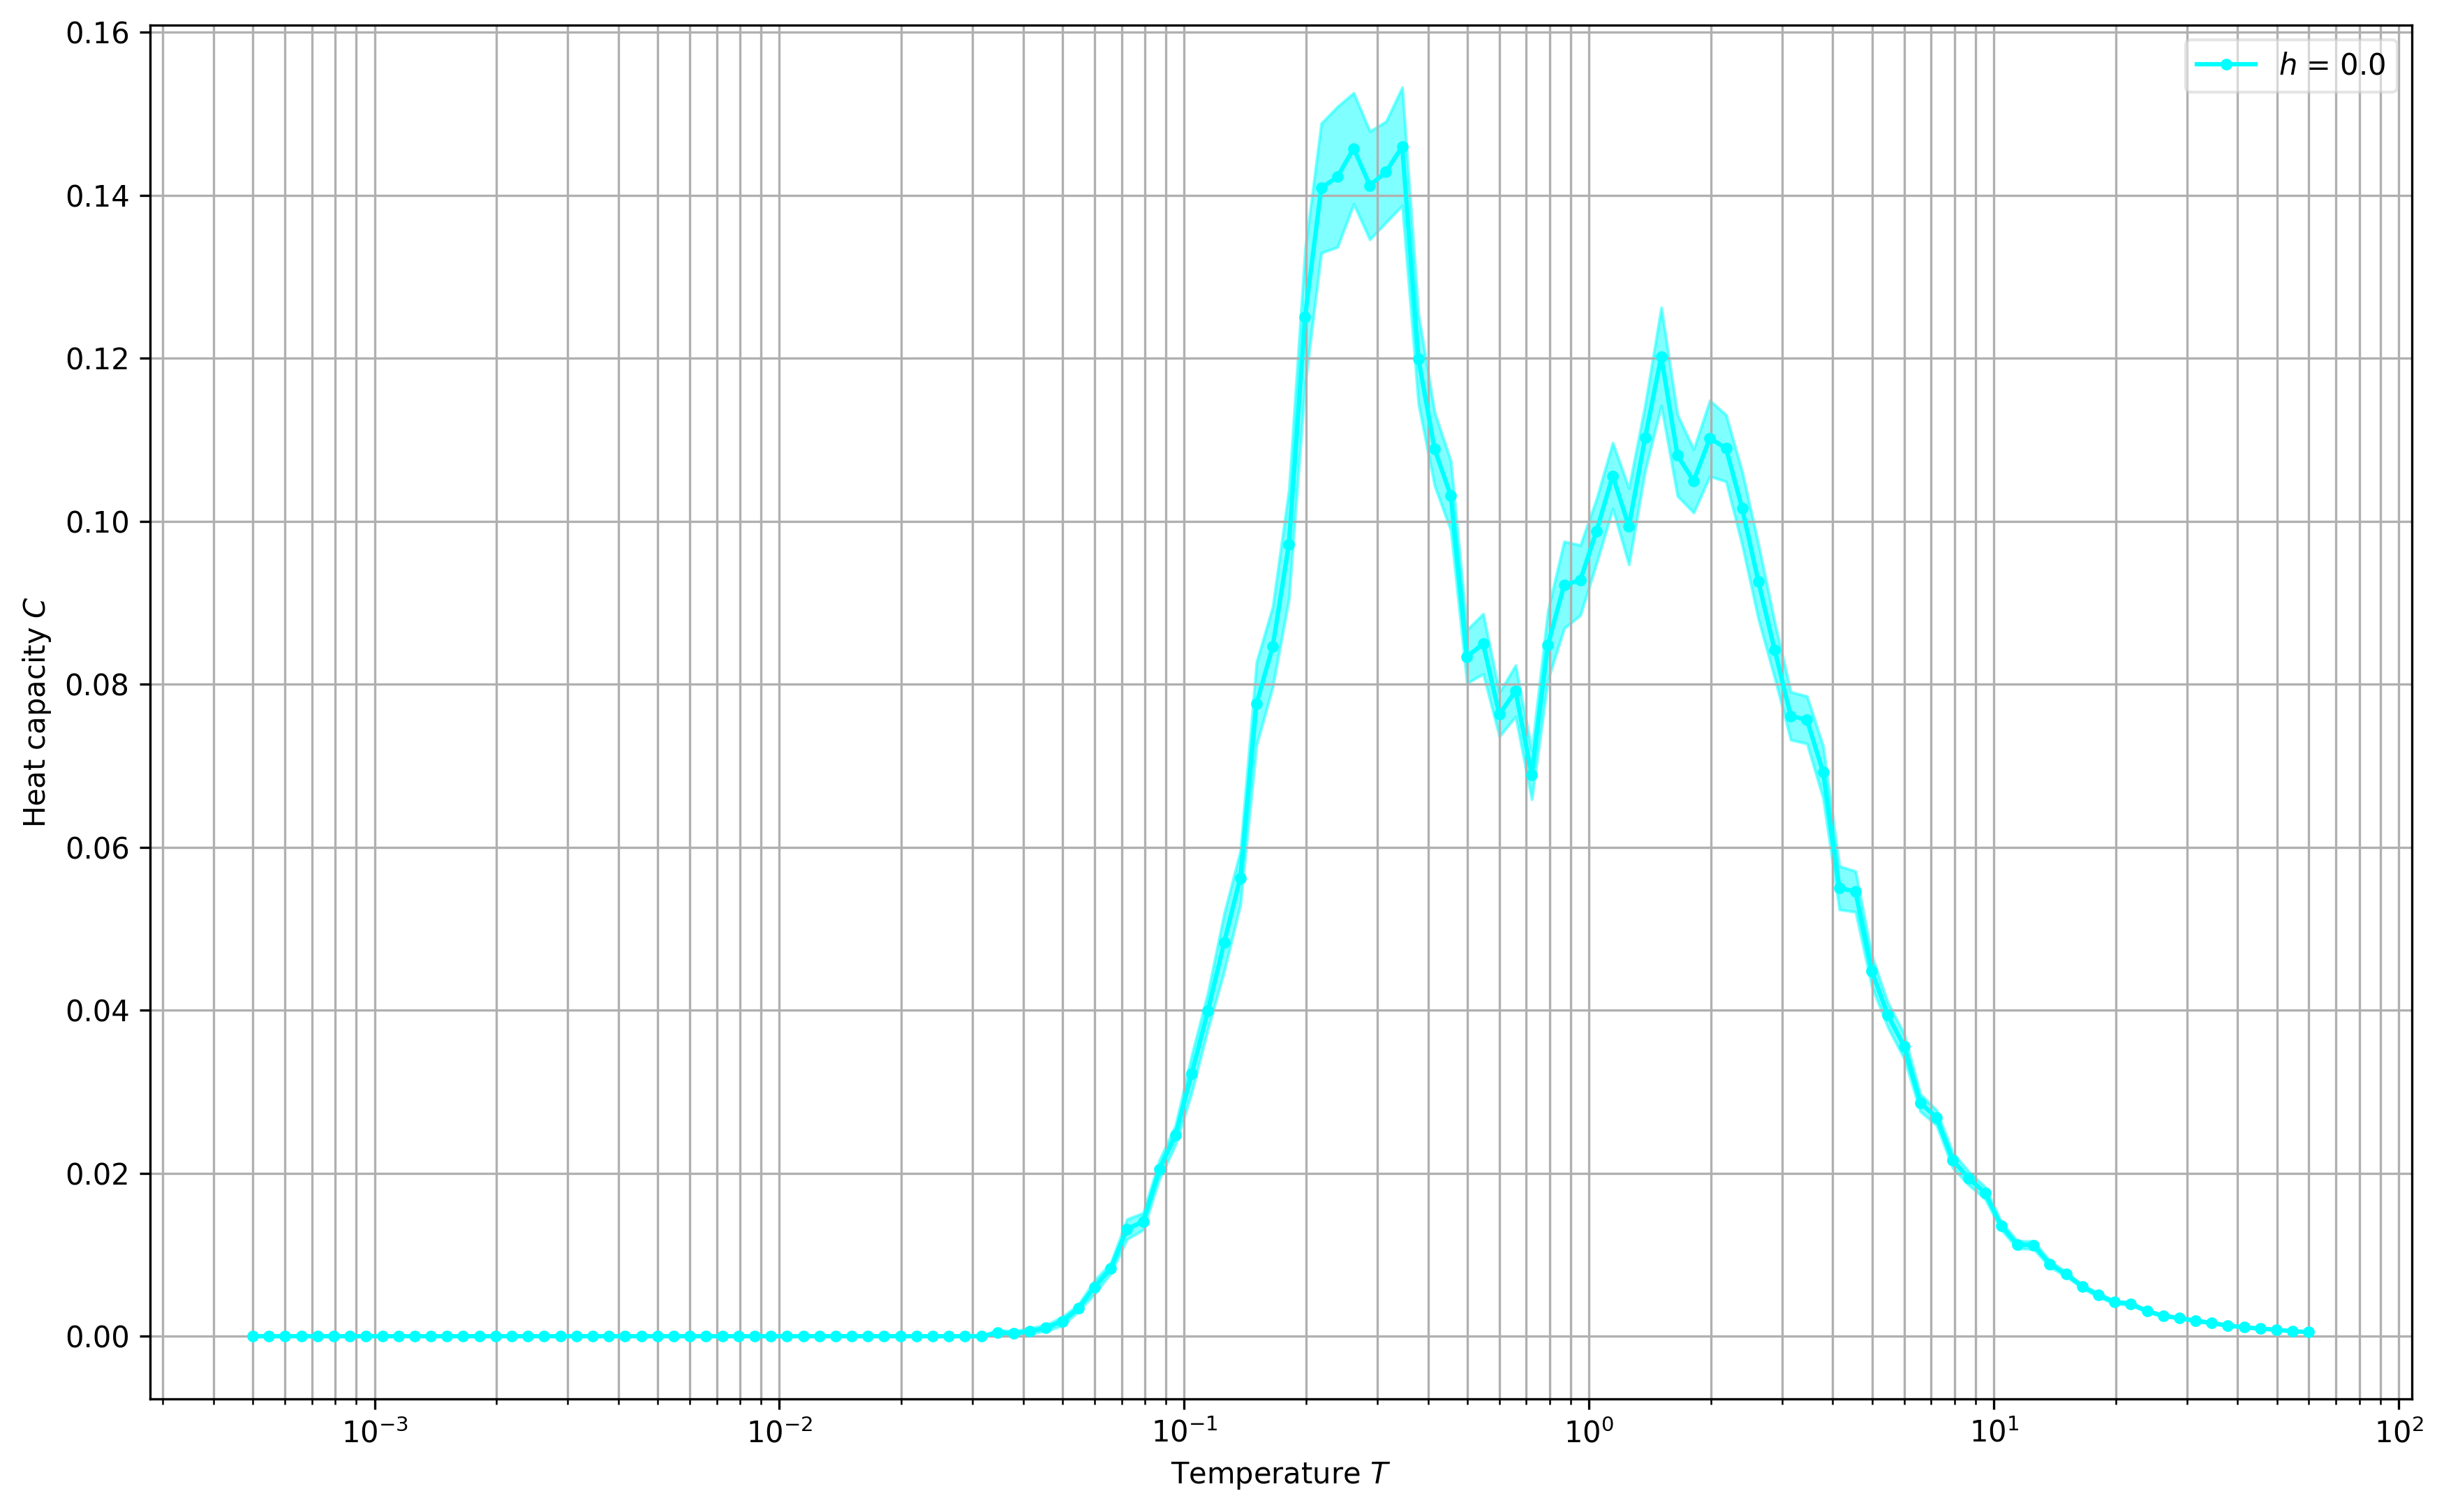

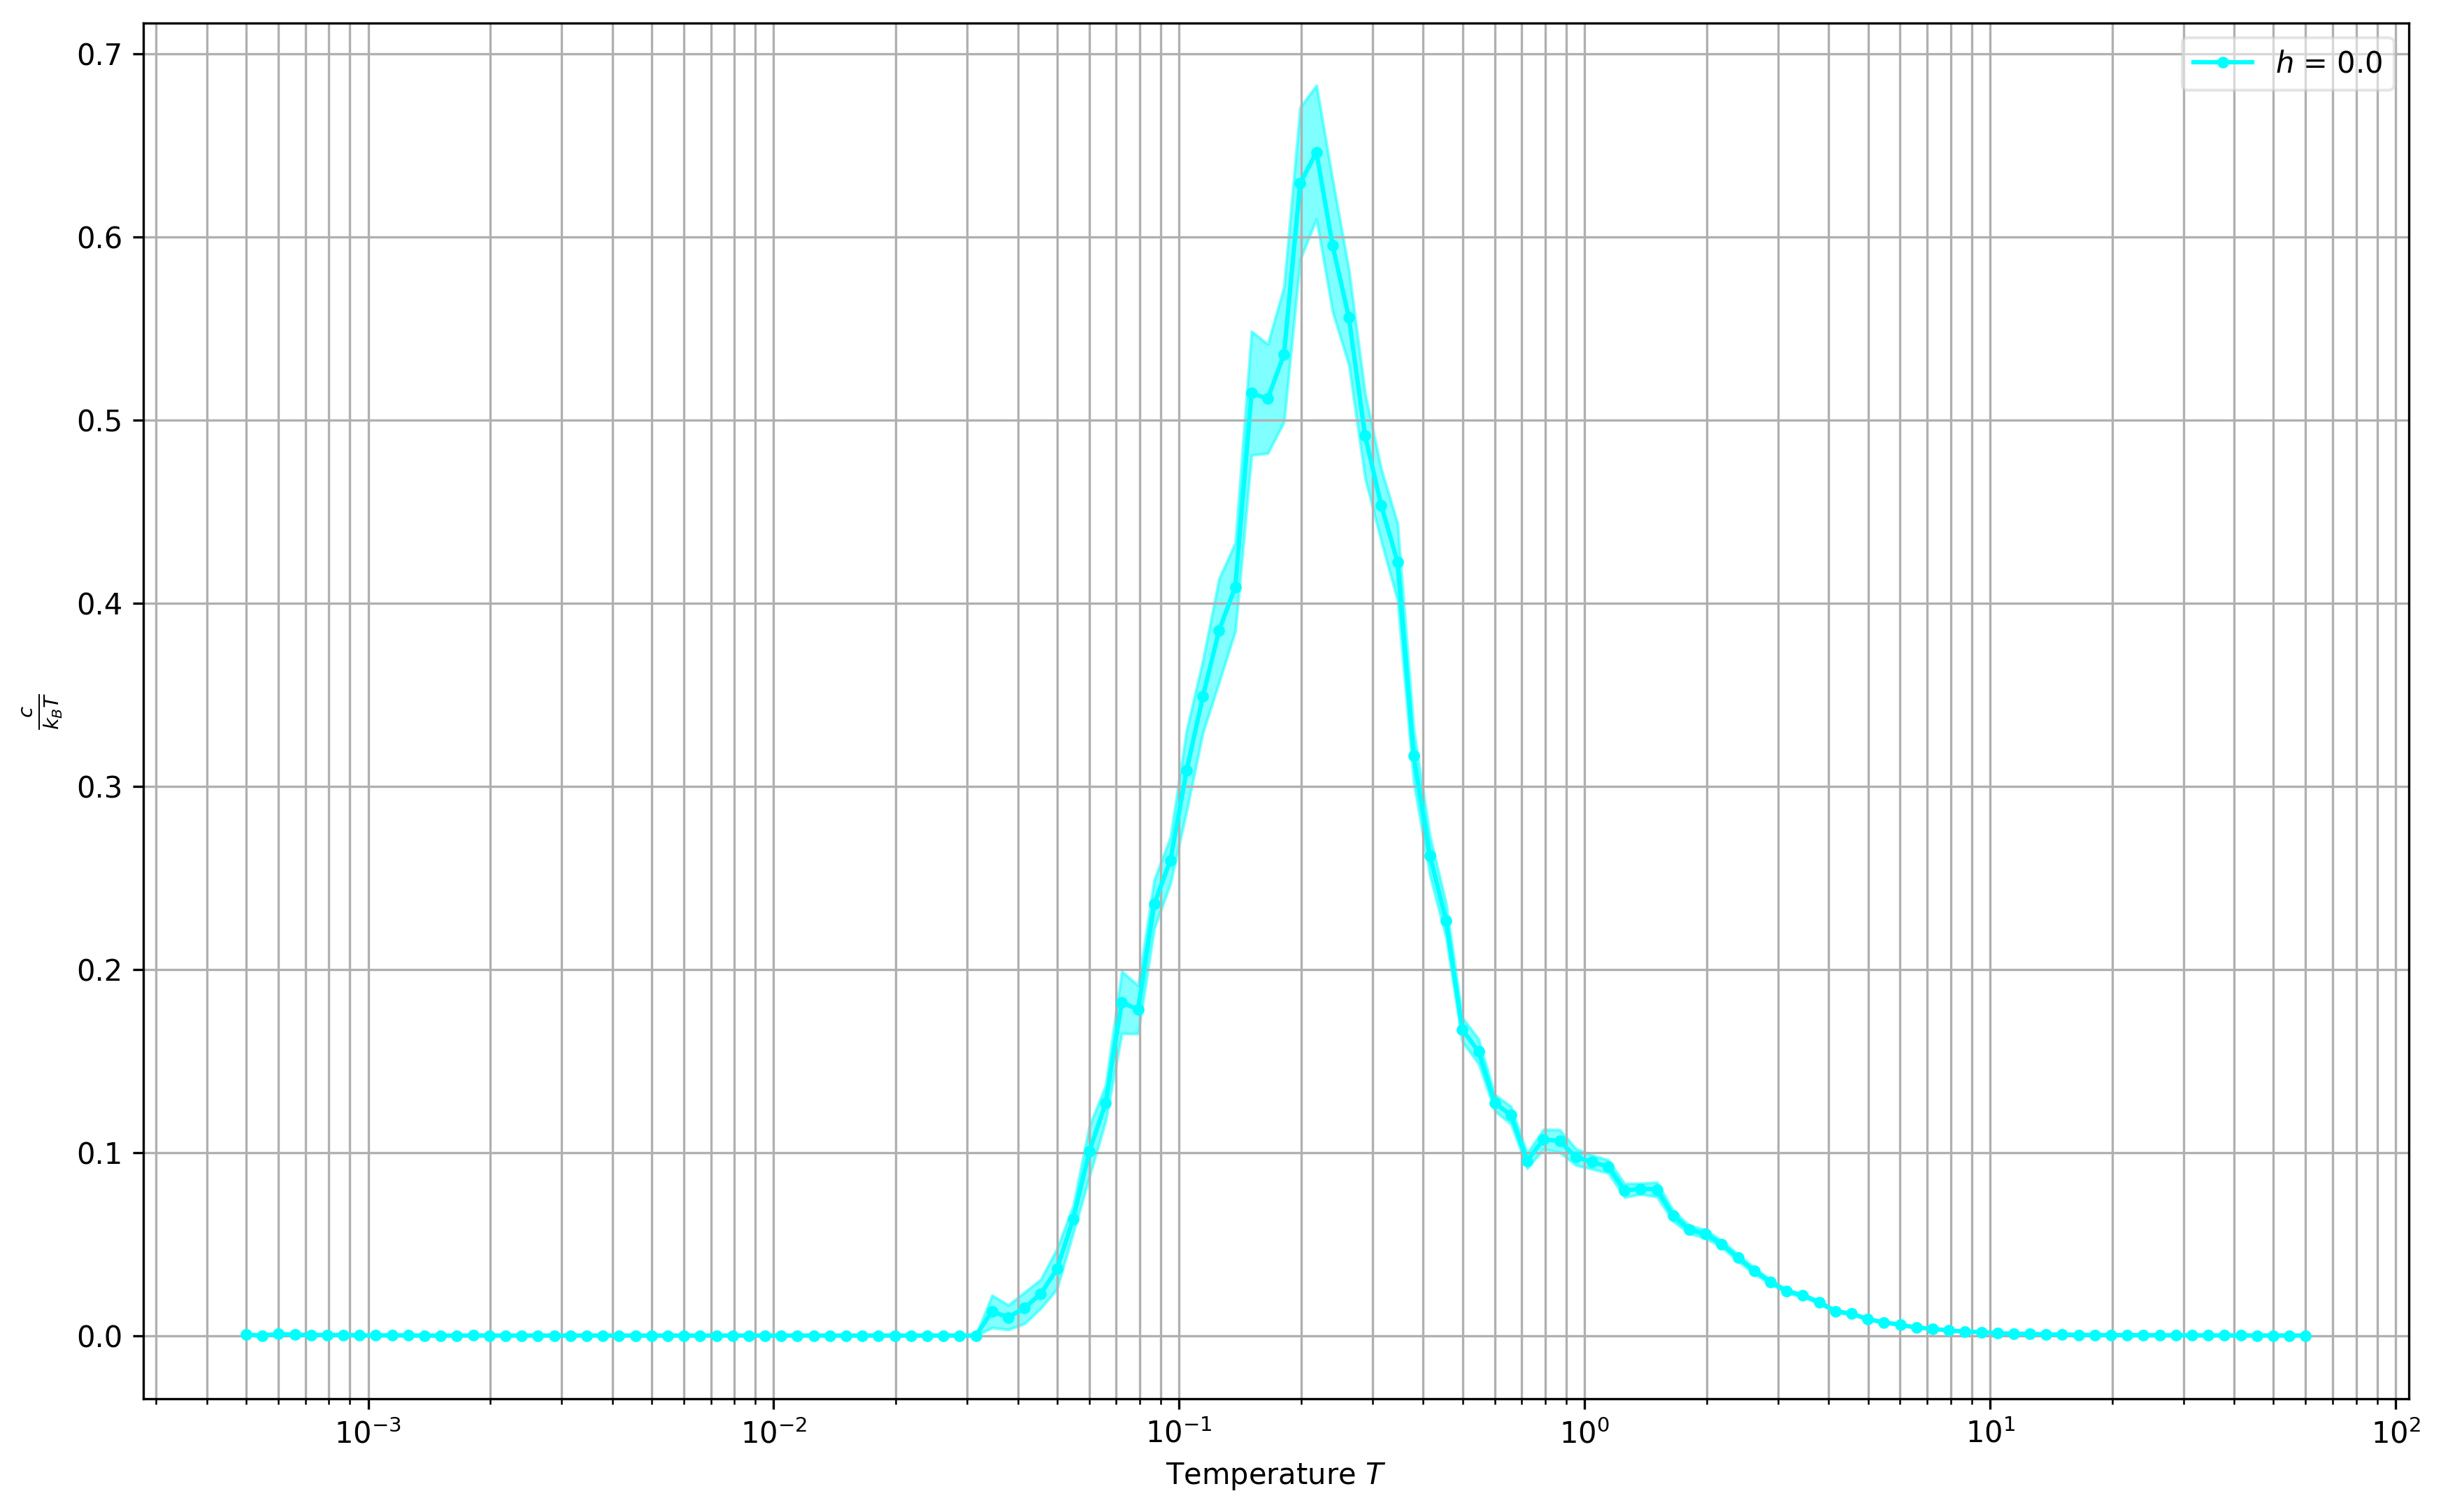

In [33]:
kw = {'binning': True, 'plzplot': False, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)

temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

Binning...Magnetisation
 bins list for binning:  [32, 16]
Binning...Magnetisation
 bins list for binning:  [32, 16]


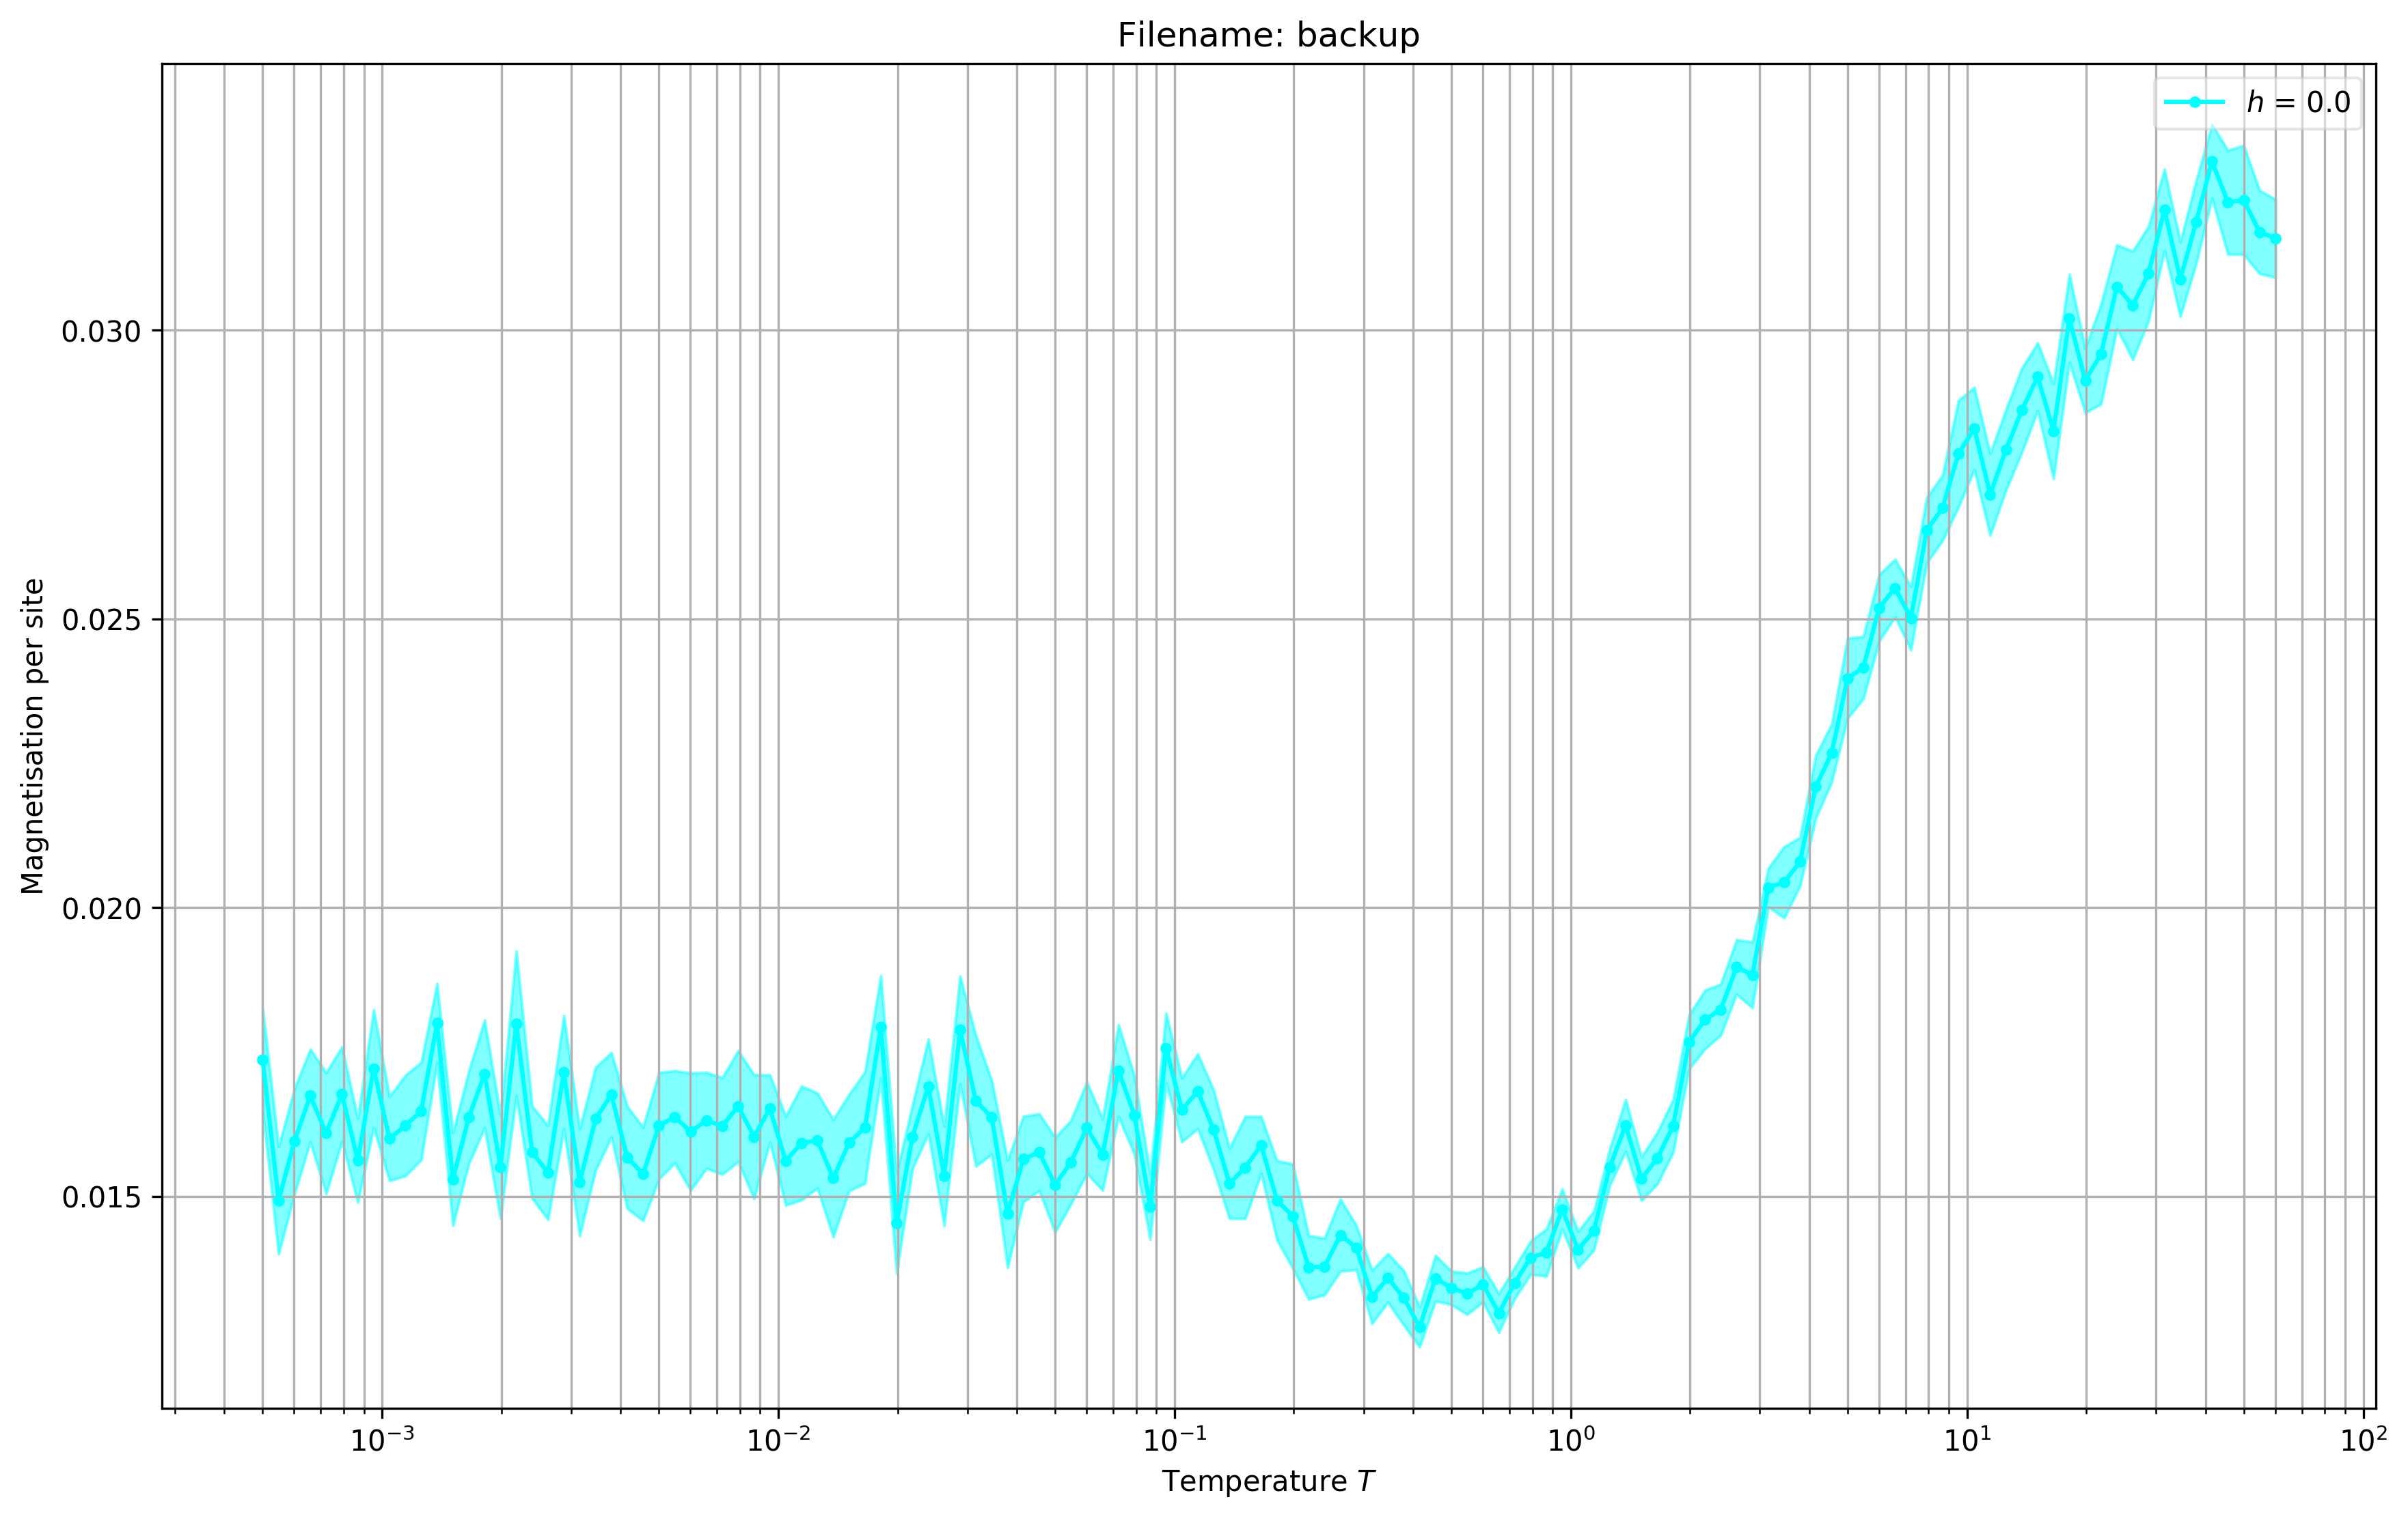

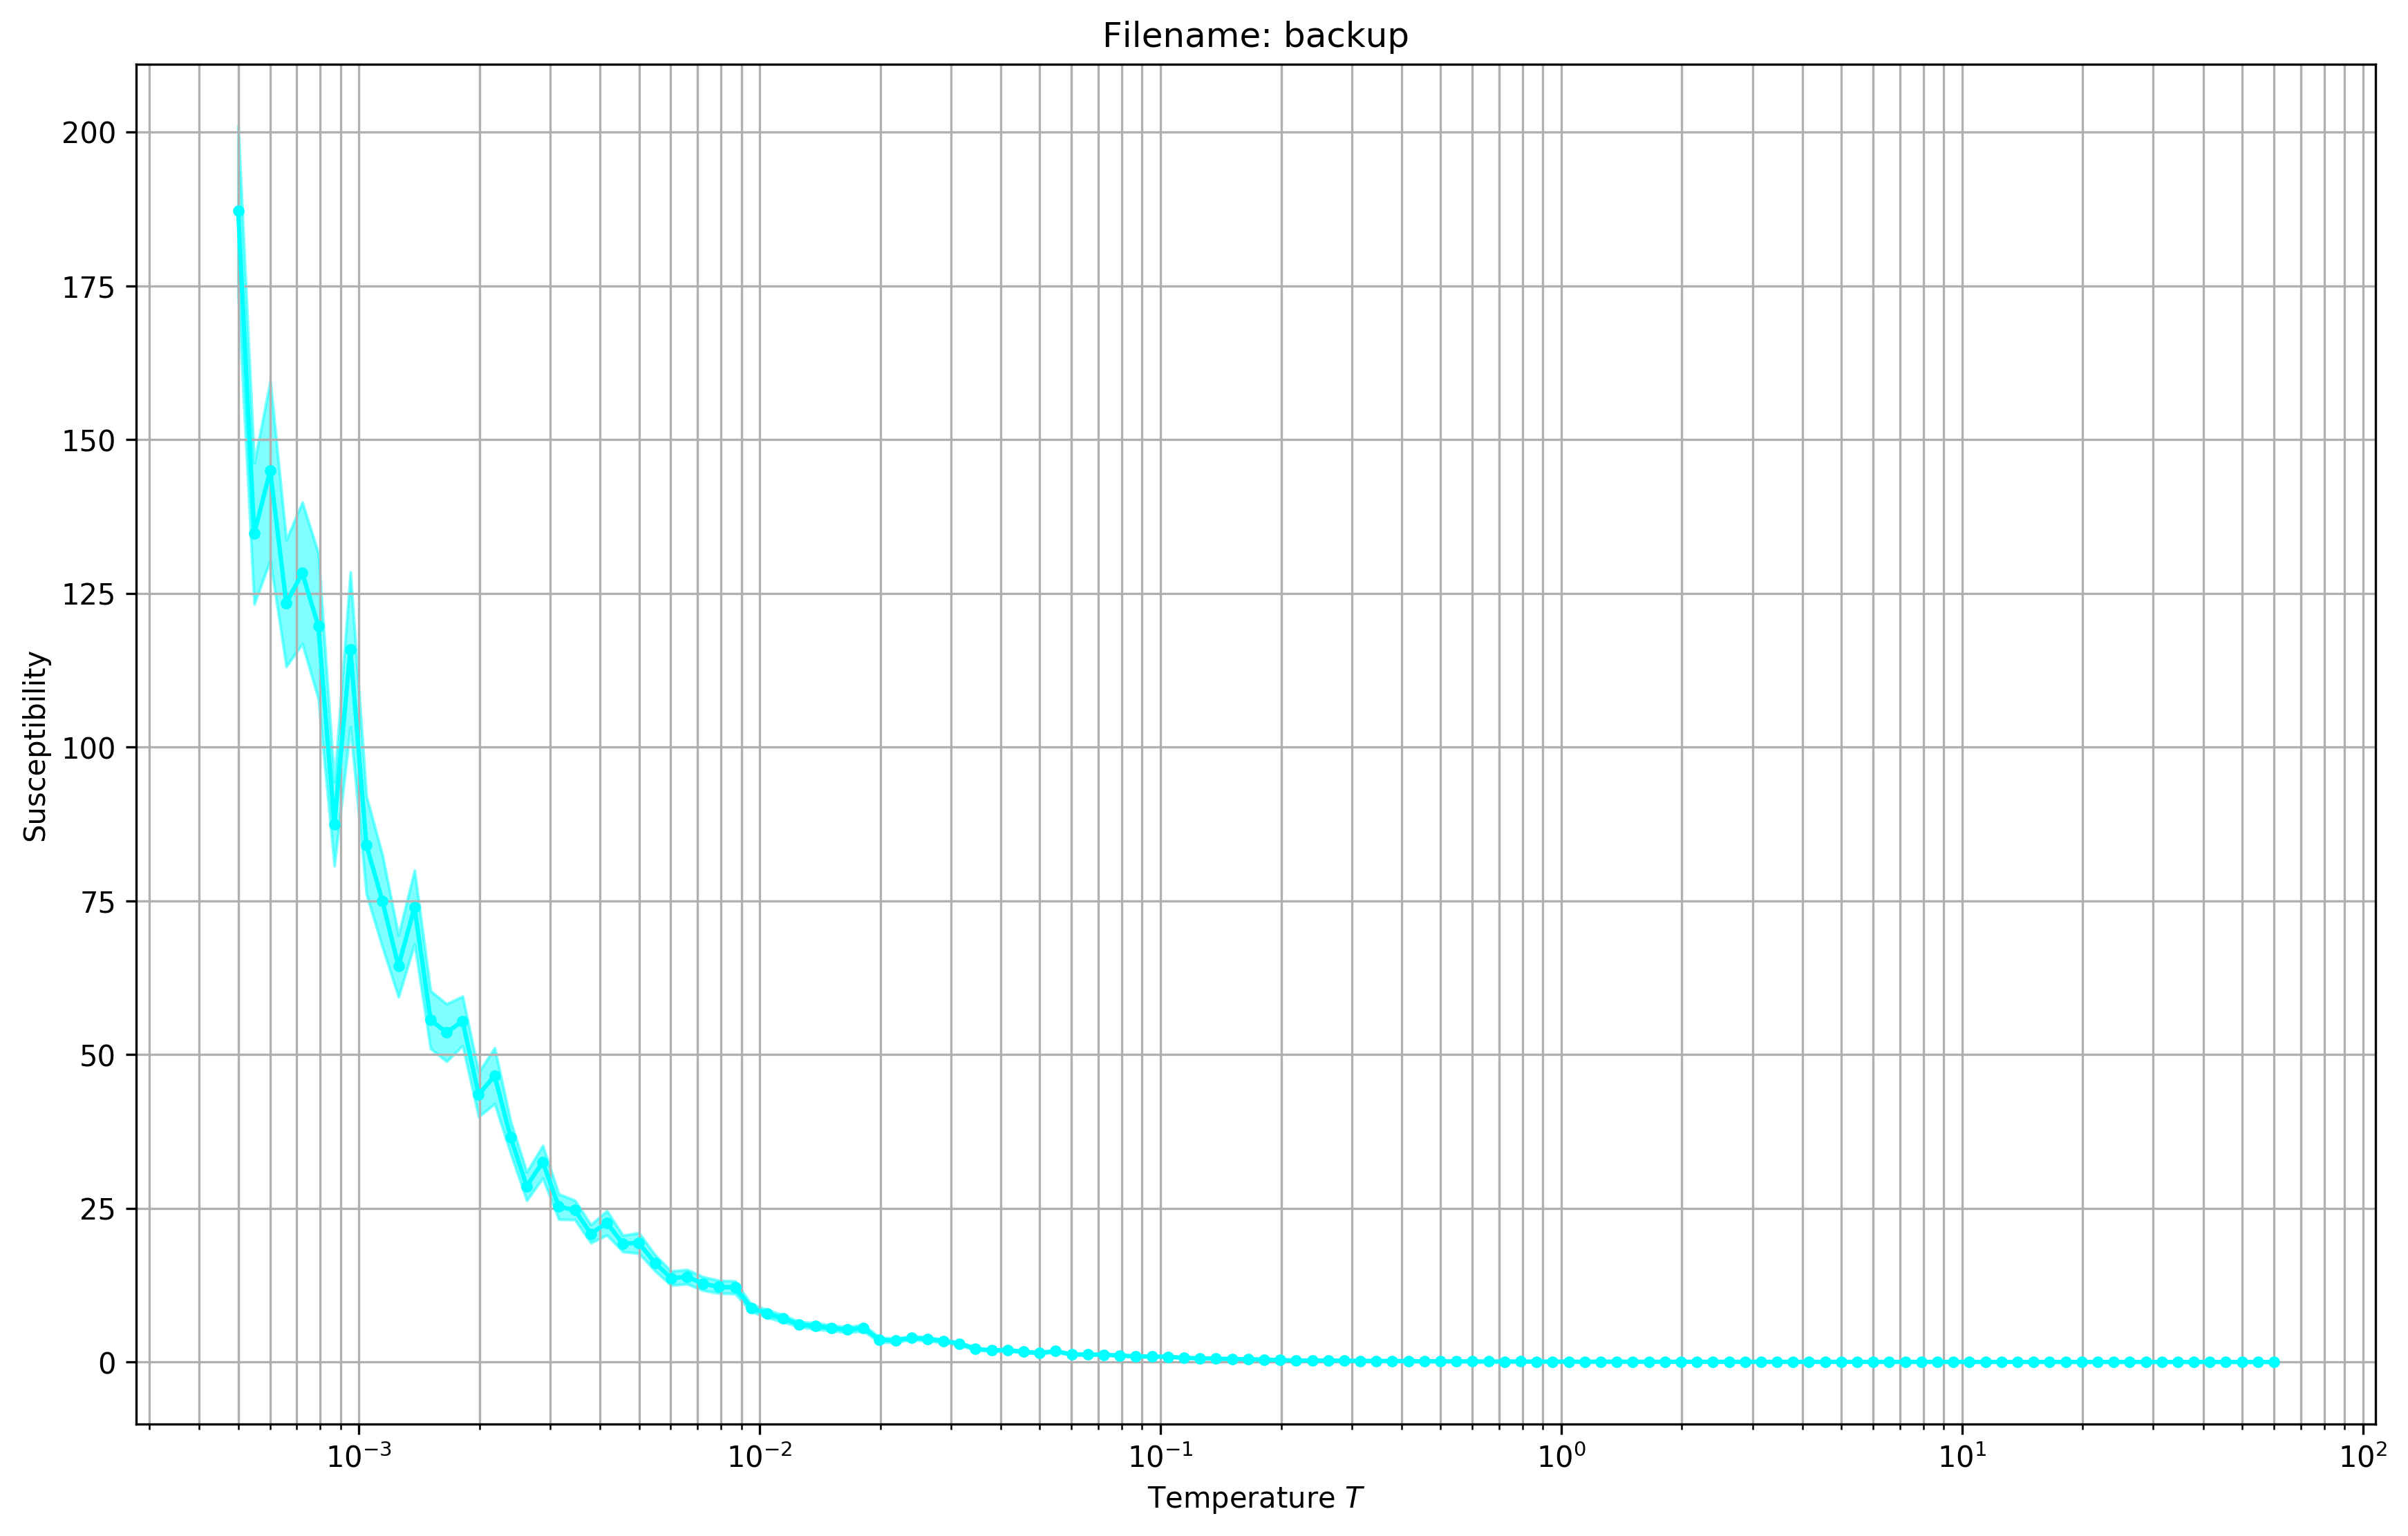

In [34]:
kw = {'binning': True, 'plzplot': False, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsM(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanM, t_h_MeanMsq, t_h_varMeanM,
                t_h_varMeanMsq, Chi, ErrChi, J1, J2, J3, J4, **kw)
plt.show()

In [35]:
rmmag = True

In [36]:
kw = {'rmmag':rmmag}
t_h_MeanFc, t_h_varMeanFc, t_h_MeanSi, t_h_varMeanSi= \
 af.LoadFirstCorrelations(foldername, filenamelist, listfunctions, stat_temps[0:4], stat_hfields, nb, t_h_varMeanMsq,**kw)


(128, 1, 4)
(128, 1, 576)


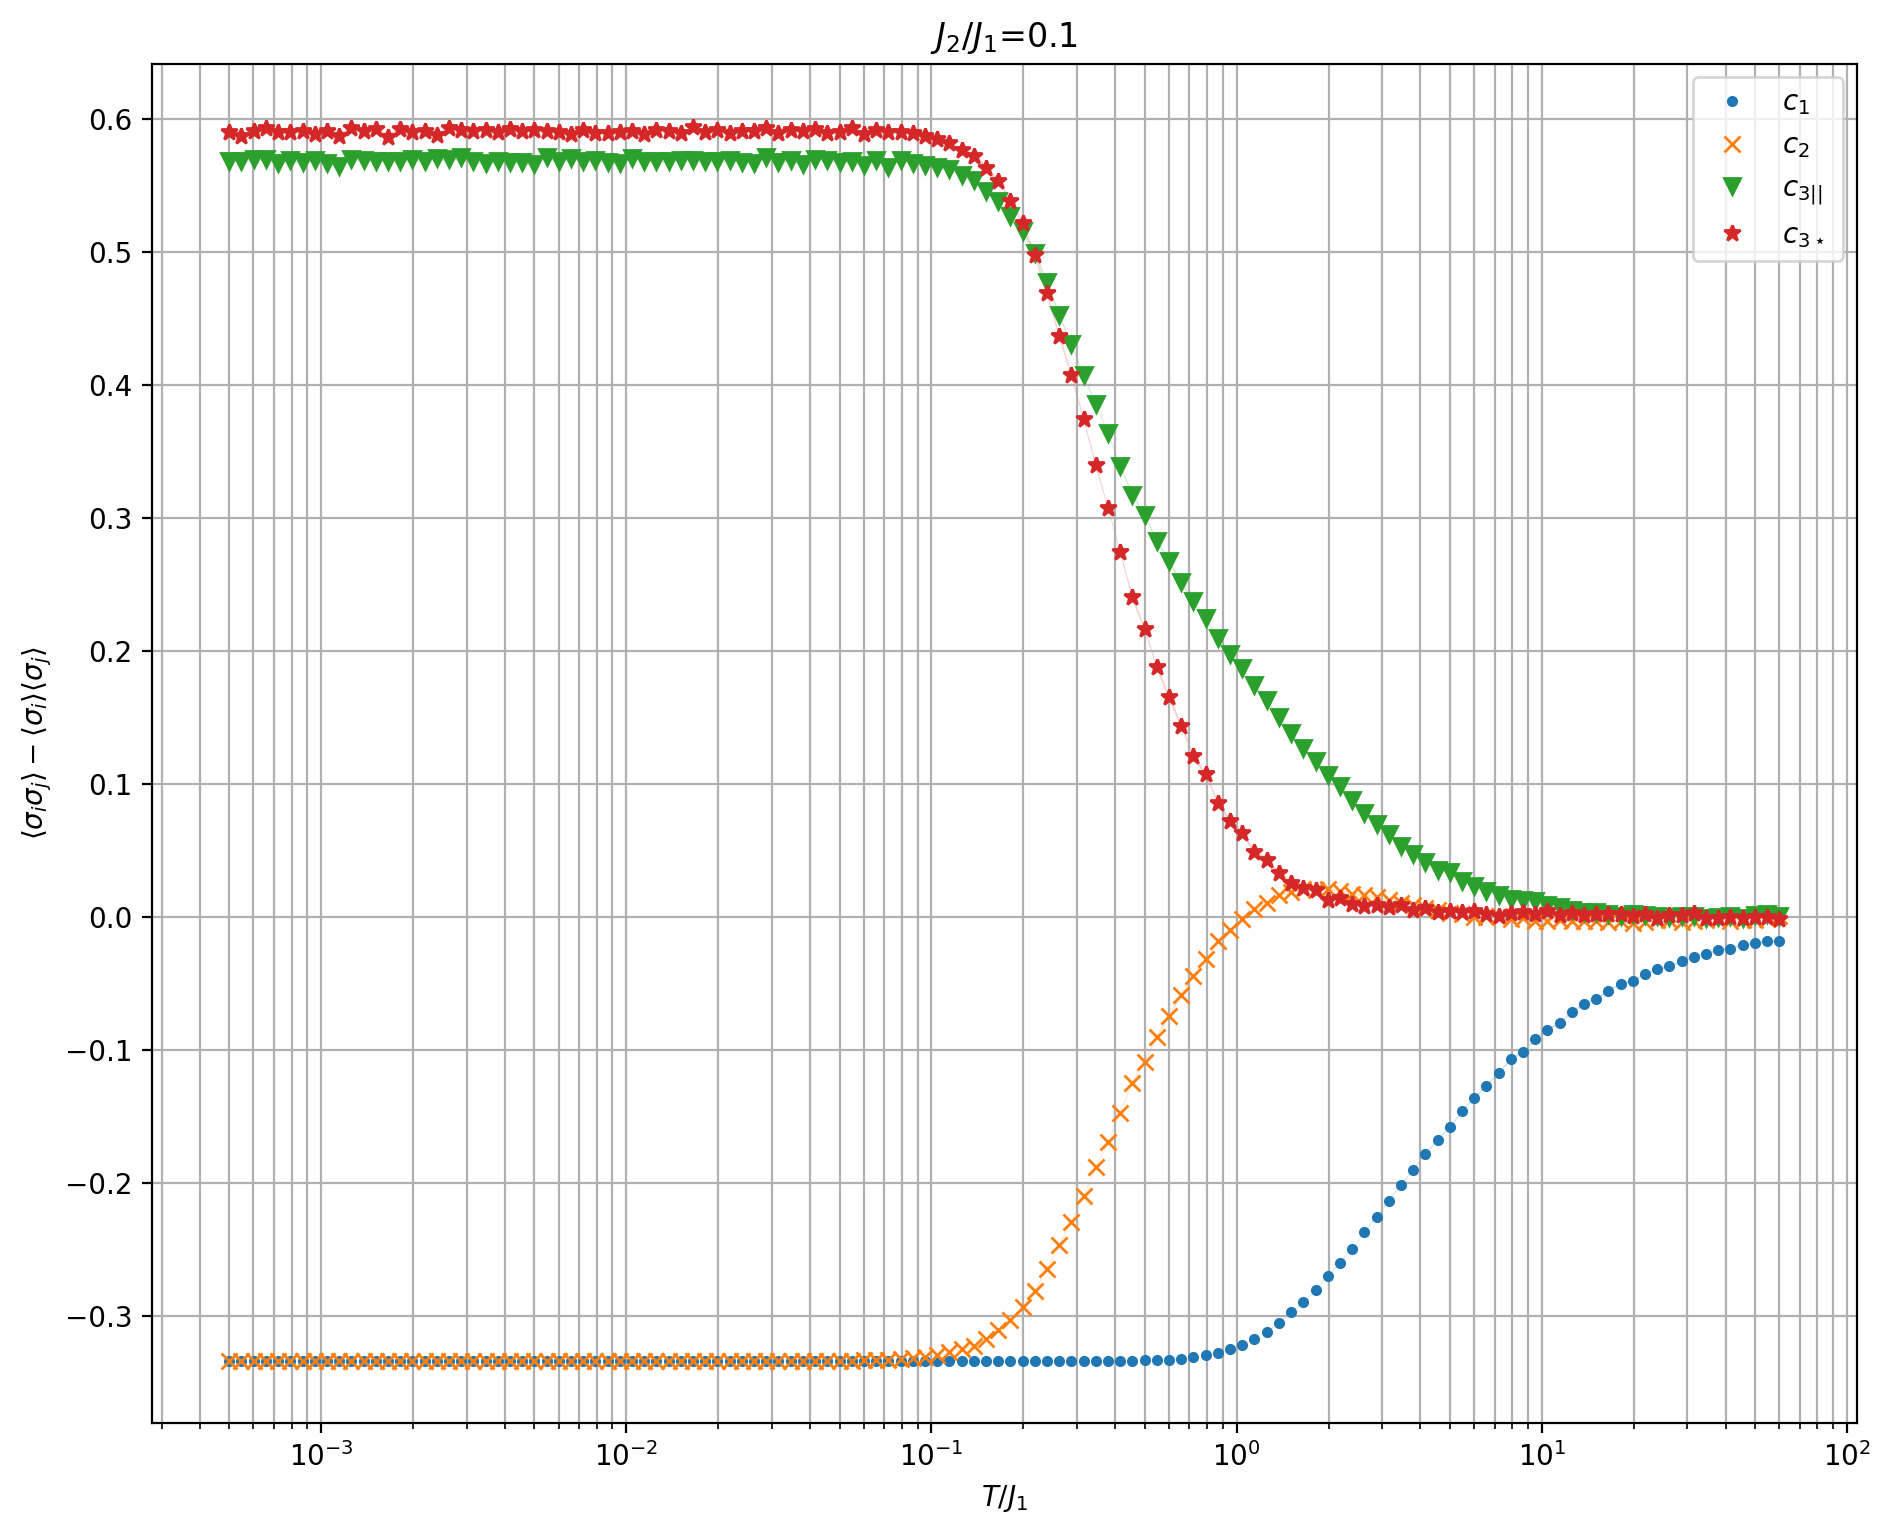

In [45]:
for i in range(n):
    addsave = "J2ovJ1" +"={:4f}".format(J2[i]/J1[i])
    addtitle = r"$J_2/J_1$={0}".format(J2[i]/J1[i])
    af.BasicPlotsFirstCorrelations(L, i, t_h_MeanFc, temperatures_plots, 
                                   t_h_varMeanFc, foldername, 
                                   results_foldername, filenamelist,
                                   tmin = 0, setyticks = np.arange(-0.3,0.7,0.1),
                                   addtitle = addtitle,
                                   save = False)
    plt.legend()
    plt.savefig("./" + foldername + results_foldername + "/FirstCorrelations_rmmag{0}.png".format(rmmag))

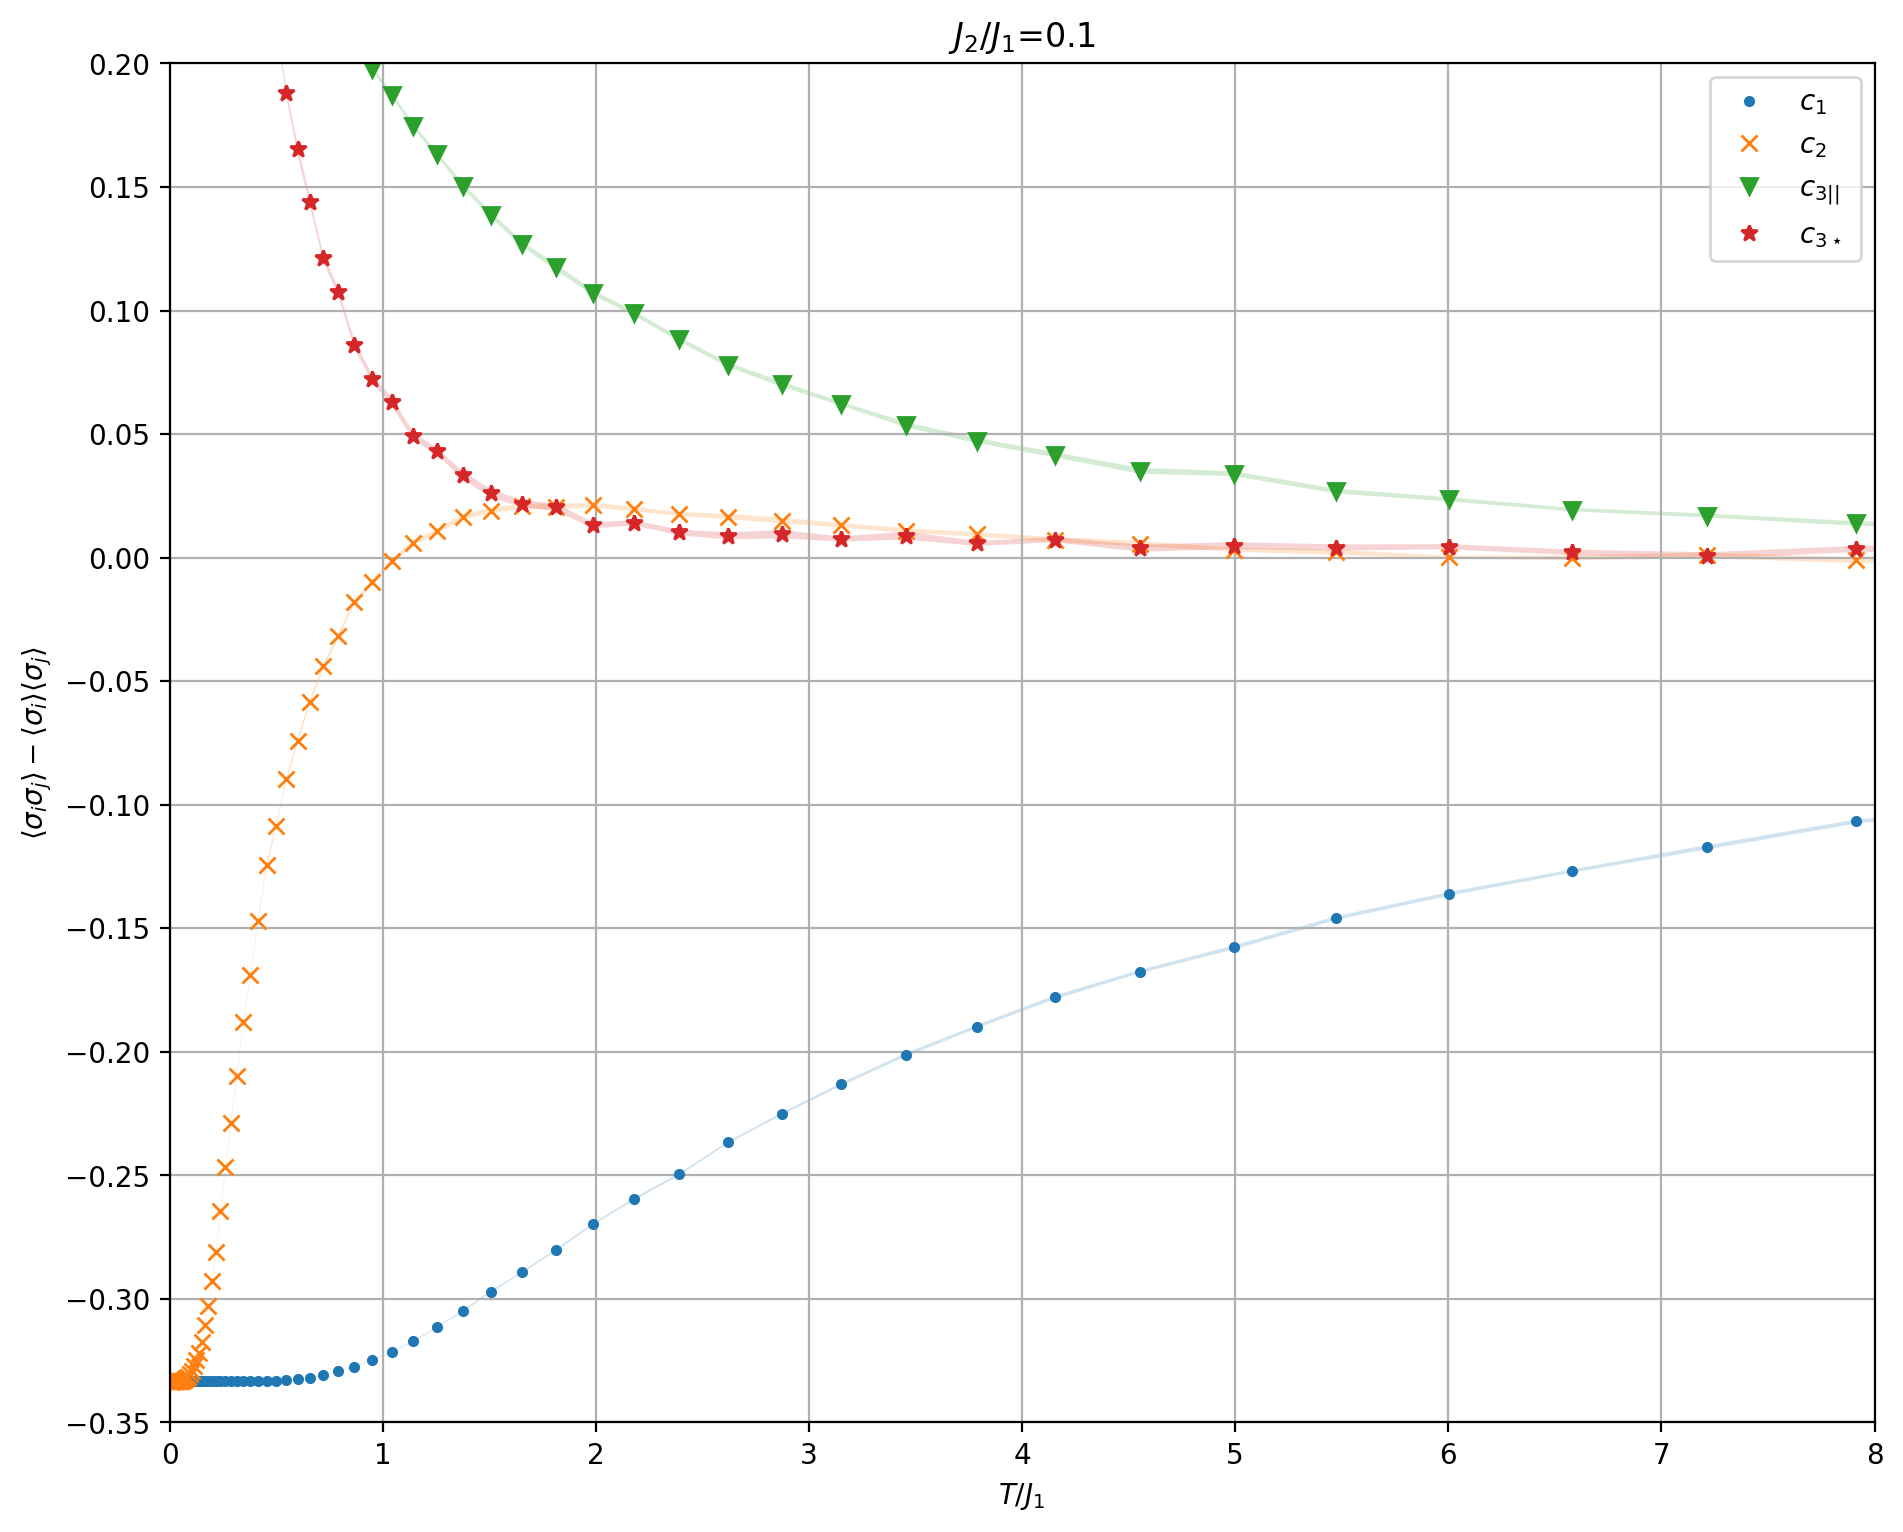

In [47]:
for i in range(n):
    addsave = "J2ovJ1" +"={0}".format(J2[i]/J1[i])
    addtitle = r"$J_2/J_1$={0}".format(J2[i]/J1[i])
    af.BasicPlotsFirstCorrelations(L, i, t_h_MeanFc, temperatures_plots, 
                                   t_h_varMeanFc, foldername, 
                                   results_foldername, filenamelist,
                                   tmin = 0, setyticks = np.arange(-0.3,0.7,0.1),
                                   addtitle = addtitle,
                                   save = False, log = False)
    plt.gca().set_prop_cycle(None)
    
    plt.xlim([0, 8])
    plt.ylim([-0.35, 0.2])
    plt.yticks(np.arange(-0.35,0.25,0.05))
    plt.legend()
    plt.savefig("./" + foldername + results_foldername + "/ZoomFirstCorrelations_Linear_rmmag{0}.png".format(rmmag))

In [48]:
kw = {'rmmag': rmmag}
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)

In [49]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
ploth = False
if not ploth:
    tid = 0
    hid = 0
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

#[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
#                                                t_h_MeanCorr,
#                                                t_h_errCorrEstim,
#                                                t_h_MeanSi,
#                                                hfields_plots,
#                                                temperatures_plots,\
#                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

t =  0.0004999999999999999
h =  0.0


[-0.29969565 -0.30524413  0.51063442  0.50898806]


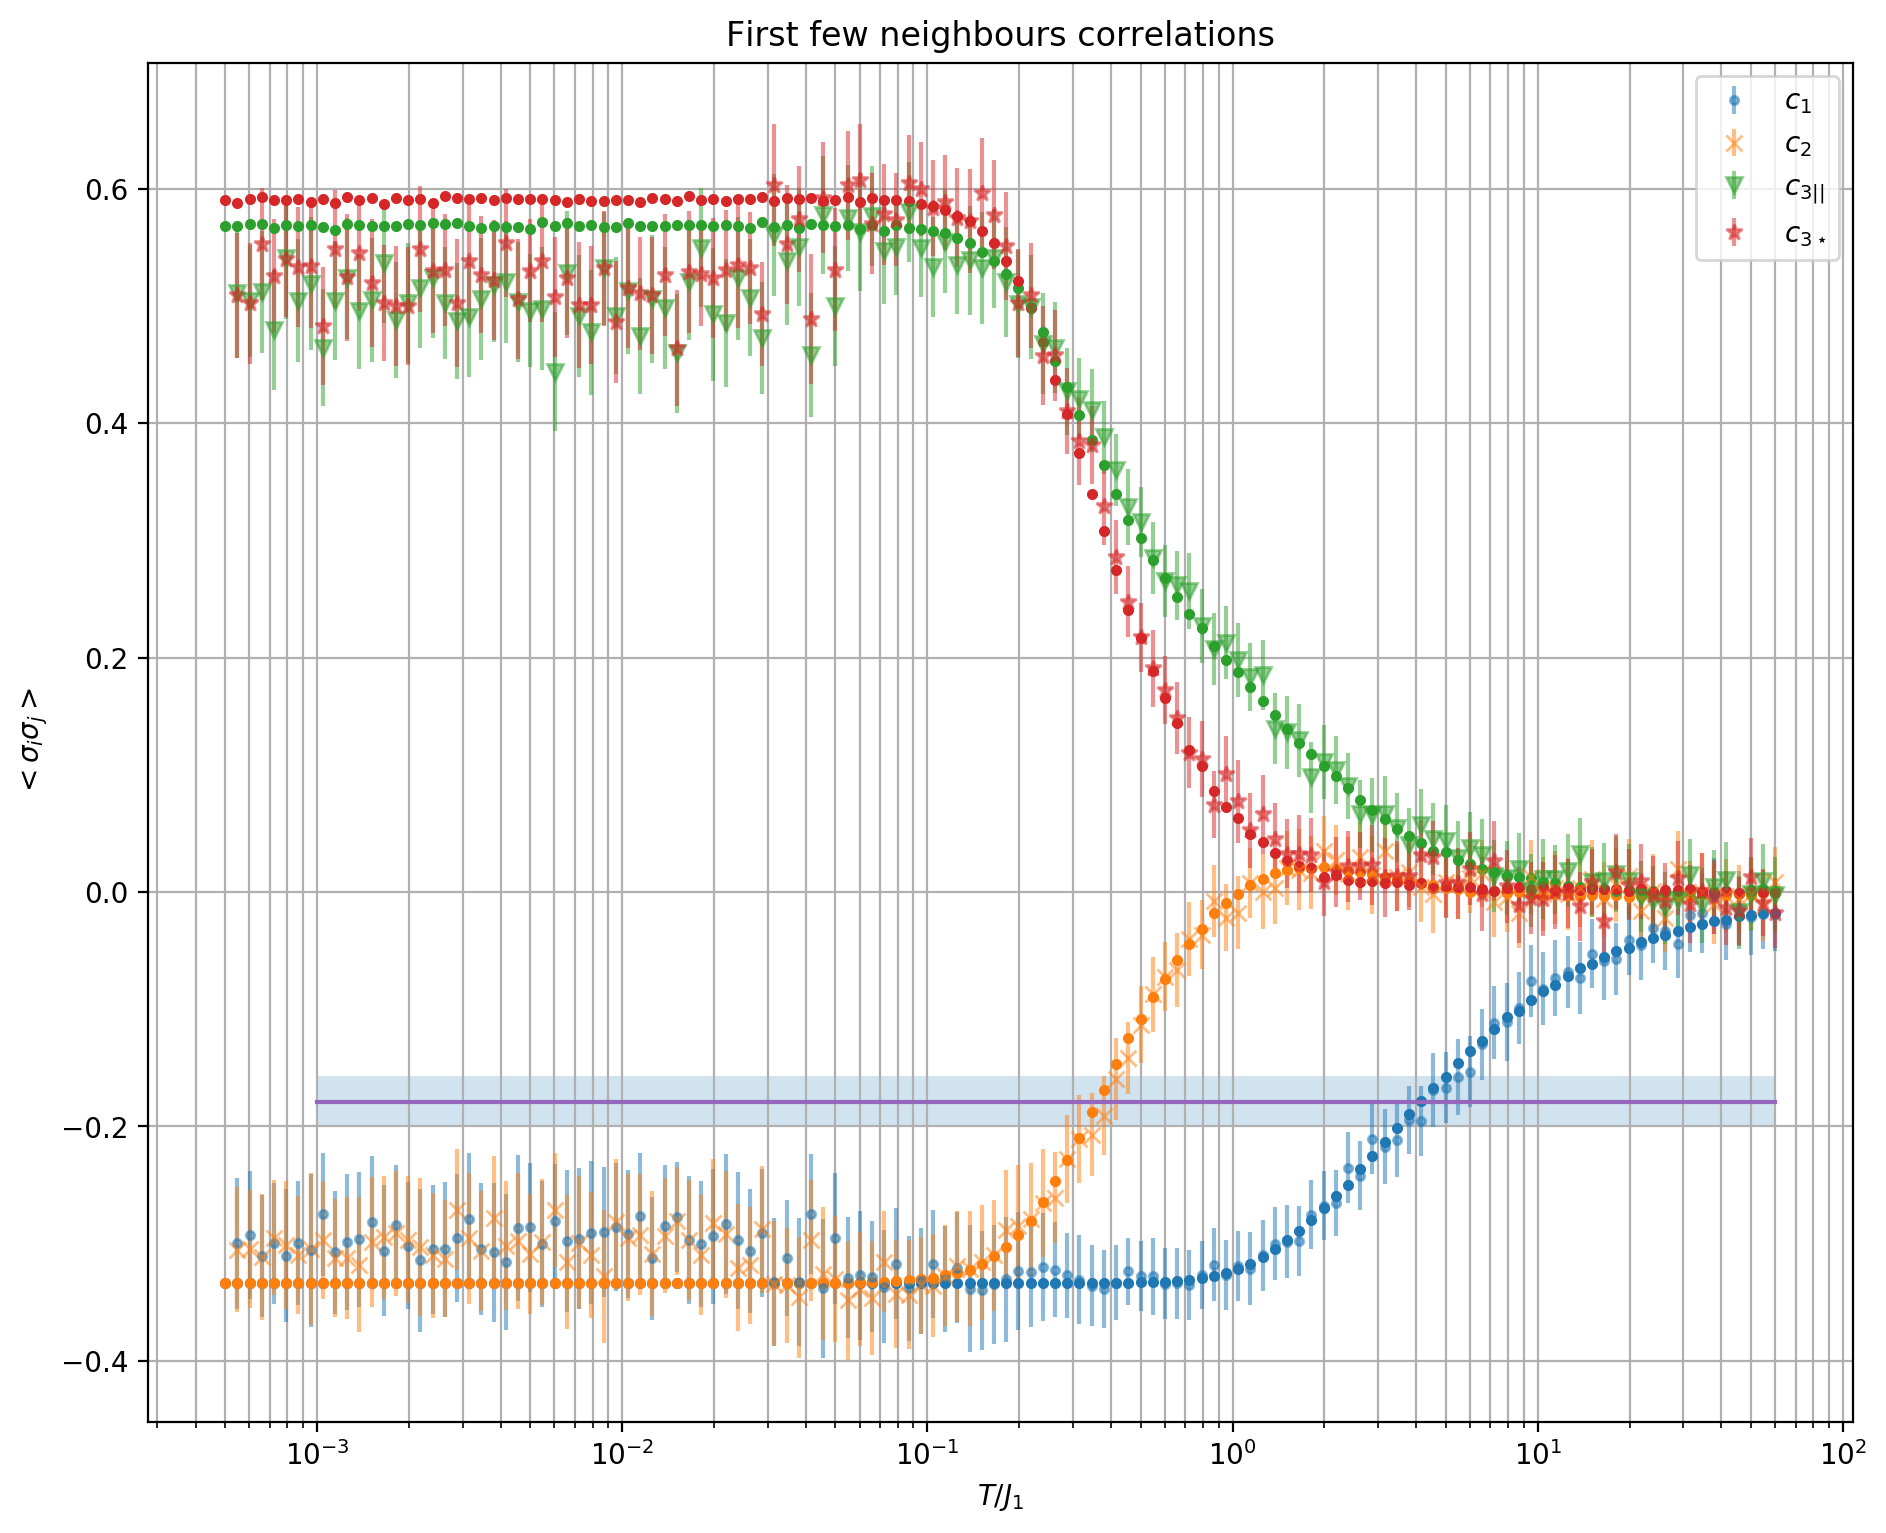

In [43]:
af.PlotFirstCorrelations(0, L,foldername, results_foldername, 
                         hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim, sref,\
                         distmax = 2, ploth = ploth,
                         plotFirst = True, t_h_MeanFc = t_h_MeanFc)
plt.plot([1e-3,60],[-0.179, -0.179])
plt.fill_between([1e-3,60],[-0.2, -0.2], [-0.157, -0.157], alpha = 0.2)

In [50]:
t_h_MeanFrustratedTriangles, t_h_varMeanFrustratedTriangles= \
 af.LoadFrustratedTriangles(foldername, filenamelist, listfunctions, stat_temps, stat_hfields, nb, **kw)

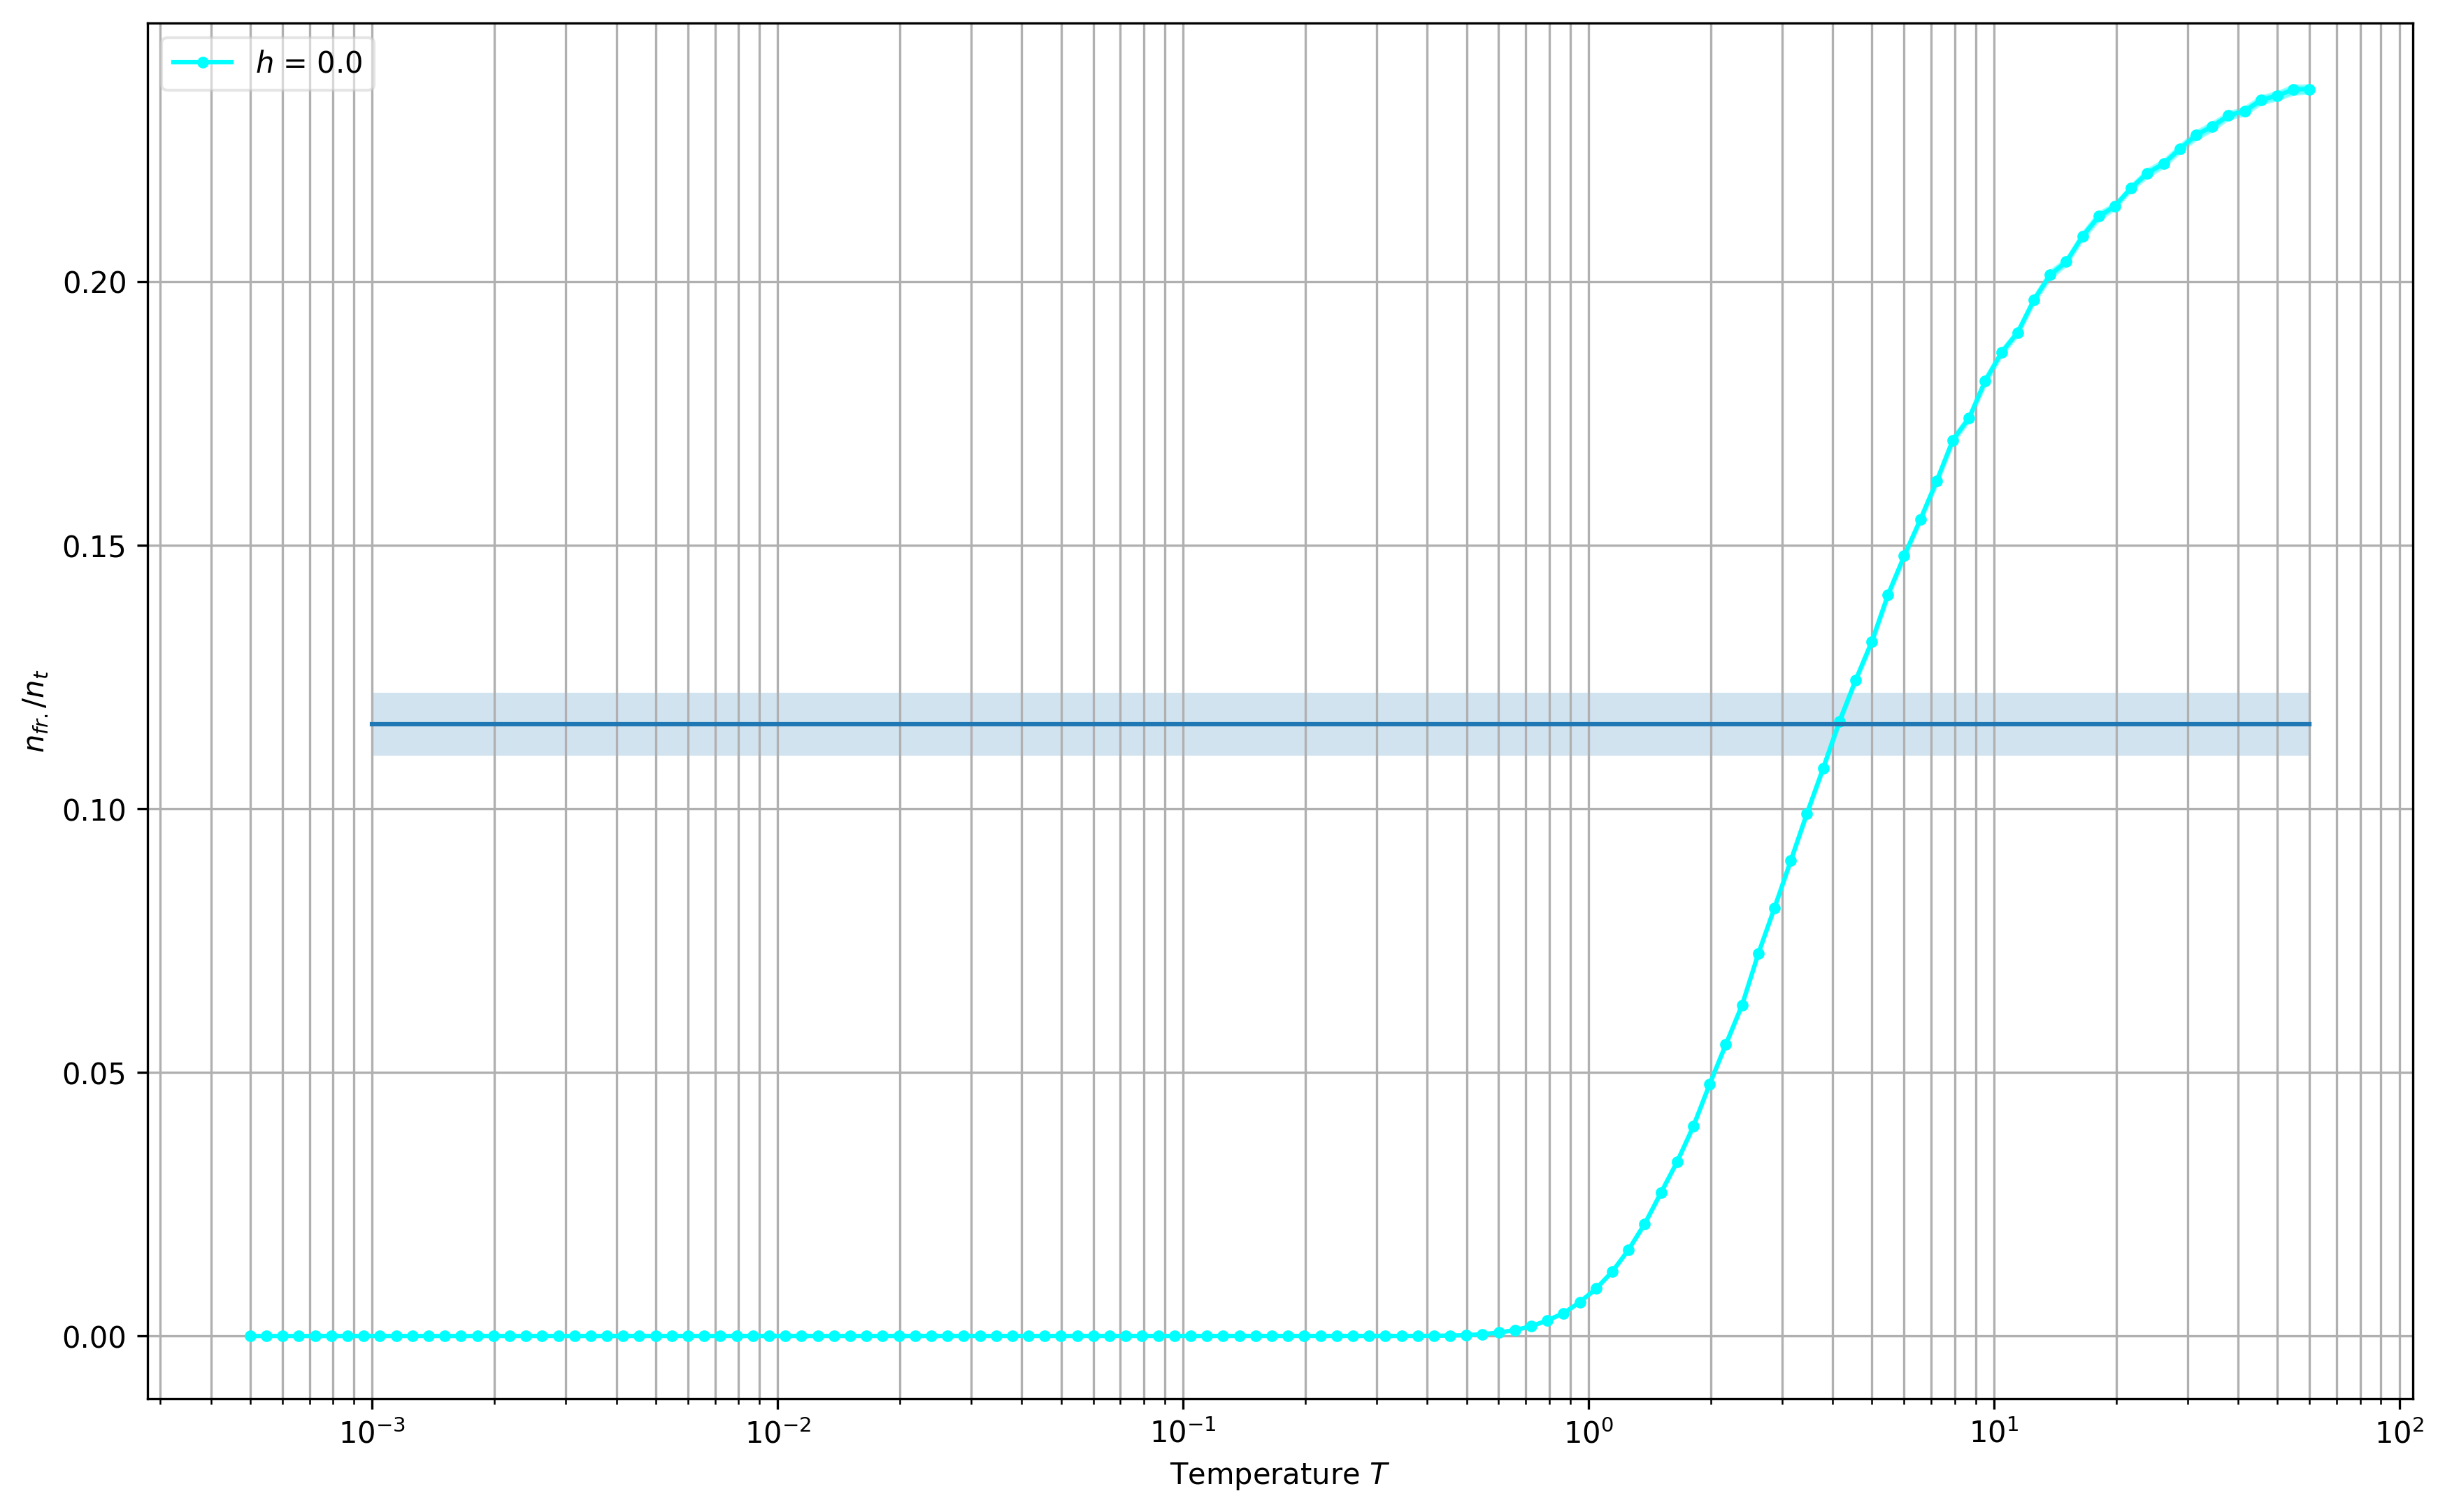

In [53]:
af.BasicPlotsTriangles(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanFrustratedTriangles,
                        t_h_varMeanFrustratedTriangles, **kw)
plt.plot([1e-3,60],[0.116, 0.116])
plt.fill_between([1e-3,60],[0.11, 0.11], [0.122, 0.122], alpha = 0.2)